In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = (12,6)

## timing data

In [3]:
dt = pd.read_csv("ttvs_h16+.tsv", delimiter='|', comment='#')
dt['tn'] = dt['tn'] + 67 # BJD-2454833
dt['pidx'] = 1
dt['pidx'][dt.KOI==620.02] = 3
dt['pidx'][dt.KOI==620.03] = 2
dt['tc'] = dt.tn + dt['O-C'] / 1440.
dt['tcerr'] = dt["e_O-C"] / 1440.
dt = dt.sort_values(["pidx", "N"]).reset_index(drop=True)

/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_40525/2364188373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['pidx'][dt.KOI==620.02] = 3
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_40525/2364188373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['pidx'][dt.KOI==620.03] = 2


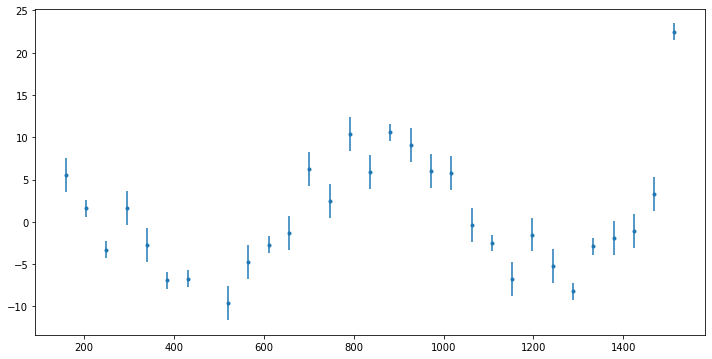

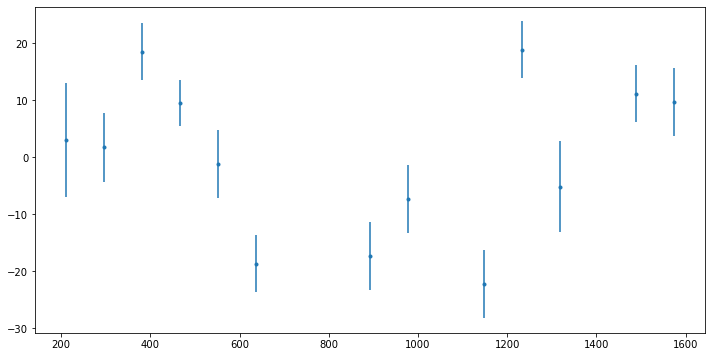

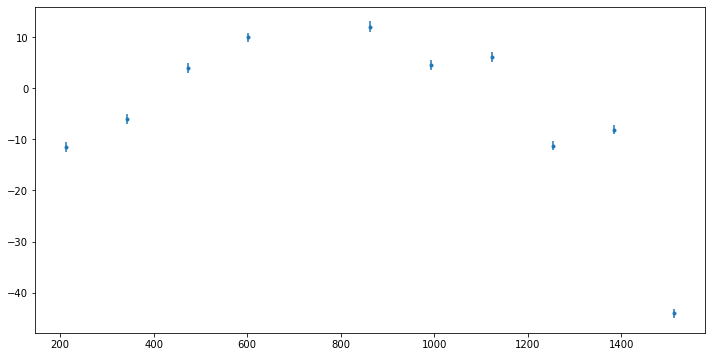

In [4]:
for pidx in [1,2,3]:
    plt.figure()
    plt.errorbar(dt[dt.pidx==pidx].tc, dt[dt.pidx==pidx]['O-C'], fmt='.', yerr=dt[dt.pidx==pidx].tcerr*1440.)

In [5]:
dt[['N', 'tc', 'tcerr', 'pidx', 'Over']].to_csv("ttvs.txt", index=False)

## lightcurve data

In [6]:
kic = 11773022

In [7]:
result_all = lk.search_lightcurve('KIC %d'%kic, author='Kepler')

In [8]:
result_all

SearchResult containing 34 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 01 2009 Kepler    1800 kplr011773022      0.0
  1 Kepler Quarter 02 2009 Kepler    1800 kplr011773022      0.0
  2 Kepler Quarter 03 2009 Kepler    1800 kplr011773022      0.0
  3 Kepler Quarter 04 2010 Kepler    1800 kplr011773022      0.0
  4 Kepler Quarter 05 2010 Kepler    1800 kplr011773022      0.0
  5 Kepler Quarter 06 2010 Kepler    1800 kplr011773022      0.0
  6 Kepler Quarter 07 2010 Kepler    1800 kplr011773022      0.0
...               ...  ...    ...     ...           ...      ...
 26 Kepler Quarter 15 2013 Kepler    1800 kplr011773022      0.0
 27 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 28 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 29 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 30 Kepler Quarter 16 2013 Kepler    1800 kplr011773022      0.0
 31 Kepler Quarter 17 2013 Kepler      60 kplr011773022      0.0
 32 Kepler Quarter 17 2013 Kepler      60 kplr011773022      0.0
 33 Kepler Quarter 17 2013 Kepler    1800 kplr011773022      0.0
Length = 34 rows

In [9]:
result_long = result_all[np.array(result_all.exptime) == 1800]
result_short = result_all[np.array(result_all.exptime) == 60]

In [10]:
result_short

SearchResult containing 17 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 12 2012 Kepler      60 kplr011773022      0.0
  1 Kepler Quarter 12 2012 Kepler      60 kplr011773022      0.0
  2 Kepler Quarter 12 2012 Kepler      60 kplr011773022      0.0
  3 Kepler Quarter 13 2012 Kepler      60 kplr011773022      0.0
  4 Kepler Quarter 13 2012 Kepler      60 kplr011773022      0.0
  5 Kepler Quarter 13 2012 Kepler      60 kplr011773022      0.0
  6 Kepler Quarter 14 2012 Kepler      60 kplr011773022      0.0
  7 Kepler Quarter 14 2012 Kepler      60 kplr011773022      0.0
  8 Kepler Quarter 14 2012 Kepler      60 kplr011773022      0.0
  9 Kepler Quarter 15 2012 Kepler      60 kplr011773022      0.0
 10 Kepler Quarter 15 2012 Kepler      60 kplr011773022      0.0
 11 Kepler Quarter 15 2013 Kepler      60 kplr011773022      0.0
 12 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 13 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 14 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 15 Kepler Quarter 17 2013 Kepler      60 kplr011773022      0.0
 16 Kepler Quarter 17 2013 Kepler      60 kplr011773022      0.0

In [47]:
lc_data = result_long.download_all()

In [11]:
sc_data = result_short.download_all()

## detrending

In [48]:
def lc_quarter(lc_data, idx):
    lc = lc_data[idx]
    t, f, e = lc.time.value, np.array(lc.pdcsap_flux).astype(np.float64), np.array(lc.pdcsap_flux_err).astype(np.float64)
    qual = np.array(lc.quality)
    idx = (t==t) * (f==f) * (e==e)
    t, f, e, qual = t[idx], f[idx], e[idx], qual[idx]
    fmed = np.median(f)
    f /= fmed
    e /= fmed
    return t, f, e, qual

from sklearn import linear_model
def design_matrix_fourier(x, df=None, fmax=None):
    if df is None:
        df = 1./(x[-1]-x[0])
    if fmax is None:
        fmax = 0.5/(np.min(np.diff(x)))
    nfou = int(np.round(fmax/df))
    ndata = len(x)
    X = np.zeros((ndata, 2*nfou+1))
    X[:,0] = np.ones(ndata)
    xmed = np.median(x)
    for i in range(nfou):
        _f = df * (i+1)
        X[:,1+2*i] = np.cos(2*np.pi*_f*(x-xmed))
        X[:,2+2*i] = np.sin(2*np.pi*_f*(x-xmed))
    return X

def irls_fit(x, y, X, n_itr=10):
    clf = linear_model.LinearRegression(fit_intercept=False)
    #clf = linear_model.Lasso(fit_intercept=False)
    sigma = np.std(y)
    delta = np.zeros_like(y)
    for i in range(n_itr):
        w = 1./np.sqrt(sigma**2+delta**2)
        w[np.abs(delta) > sigma] = 0.
        reg = clf.fit(X, y, sample_weight=w)
        ypred = reg.predict(X)
        delta = y - ypred
        sigma = np.std(delta)
    return ypred

def fourier_baseline(t, f, filter_period):
    df = min(0.3/filter_period, 1./(t[-1]-t[0])*0.5)
    X = design_matrix_fourier(t, fmax=1./filter_period, df=df)
    fbase = irls_fit(t, f, X)
    return fbase

In [80]:
tlist, flist, elist, qlist = [], [], [], []
for q in range(len(lc_data)):
    t, f, e, qual = lc_quarter(lc_data, q)
    tlist.append(t)
    flist.append(f)
    elist.append(e)
    qlist.append(qual)

In [81]:
filter_period = 1.5

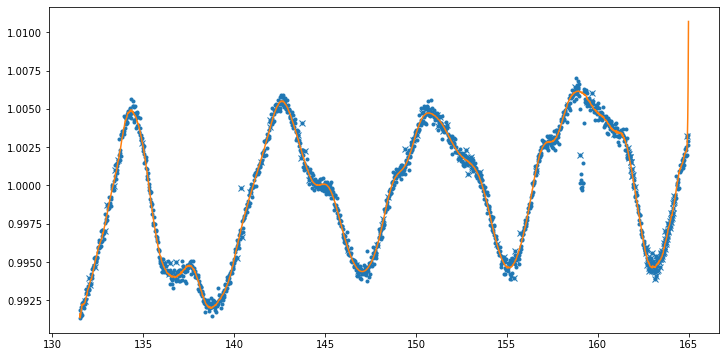

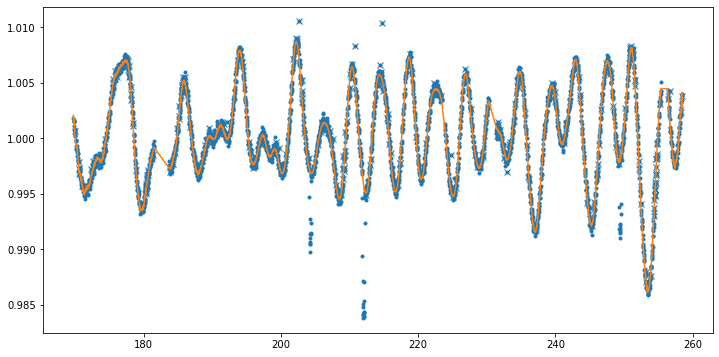

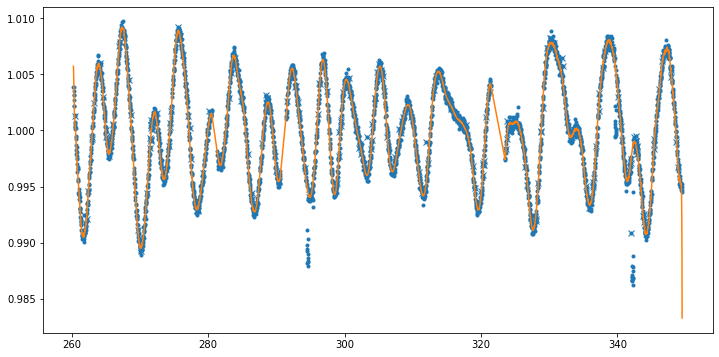

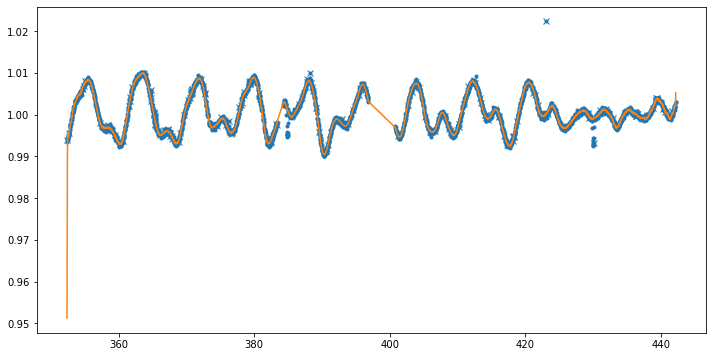

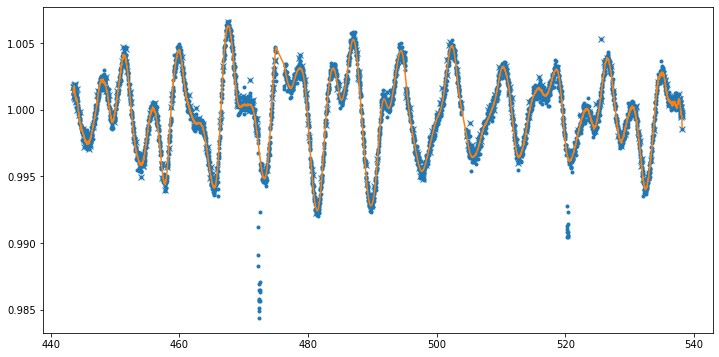

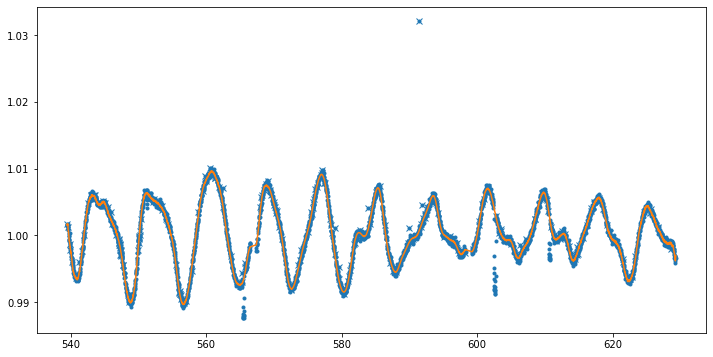

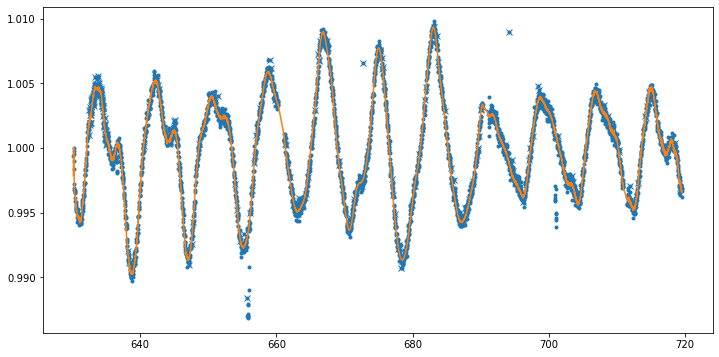

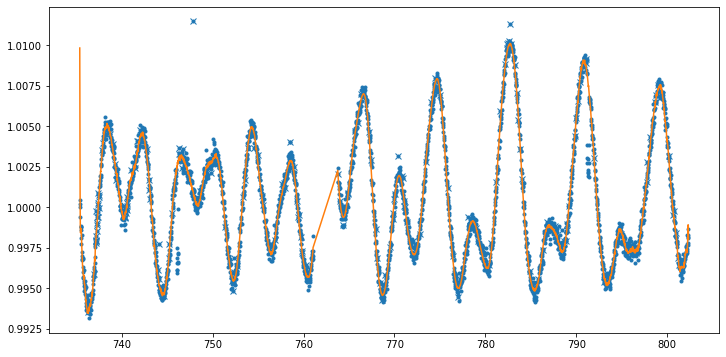

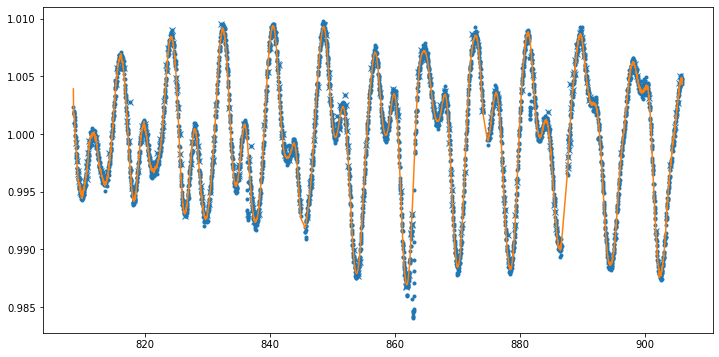

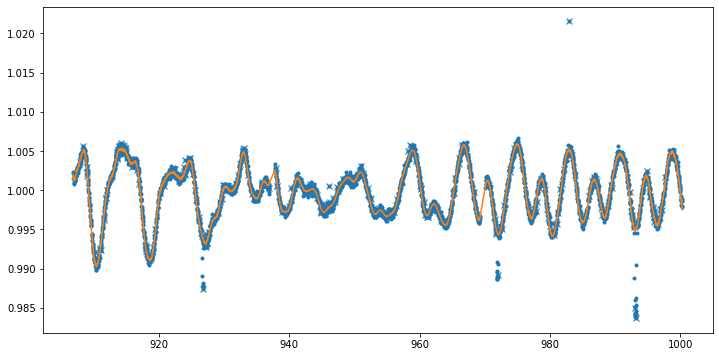

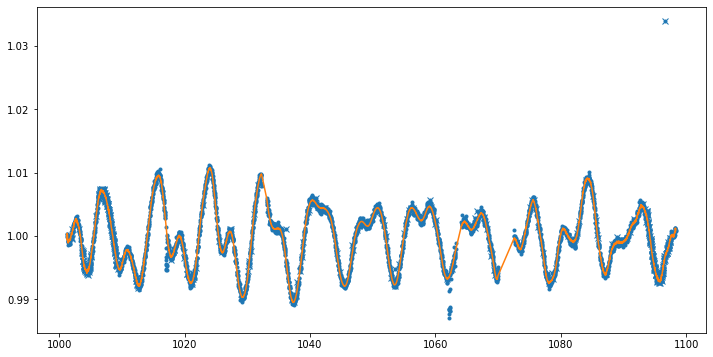

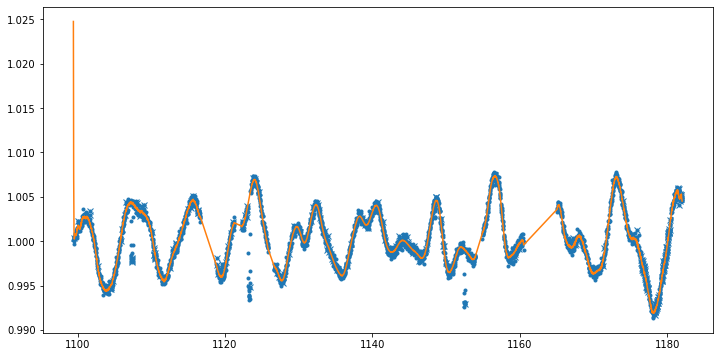

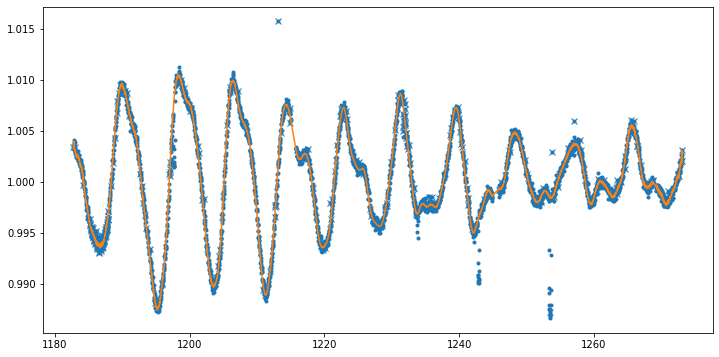

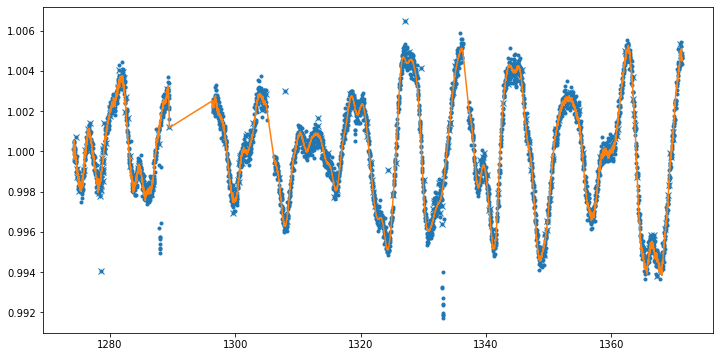

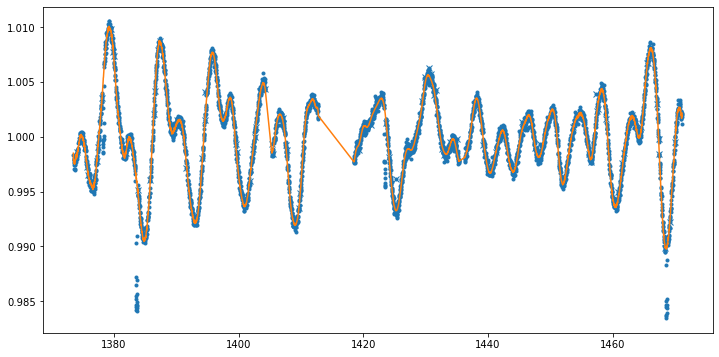

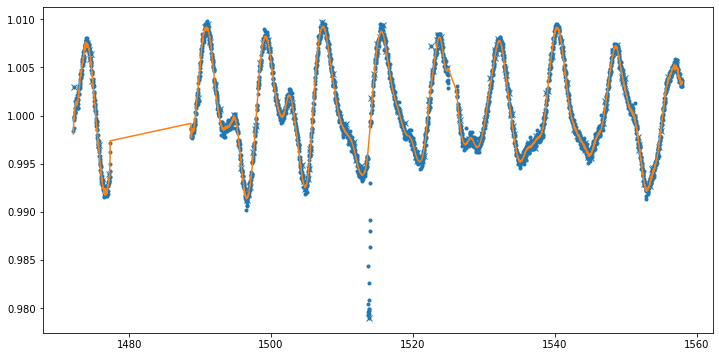

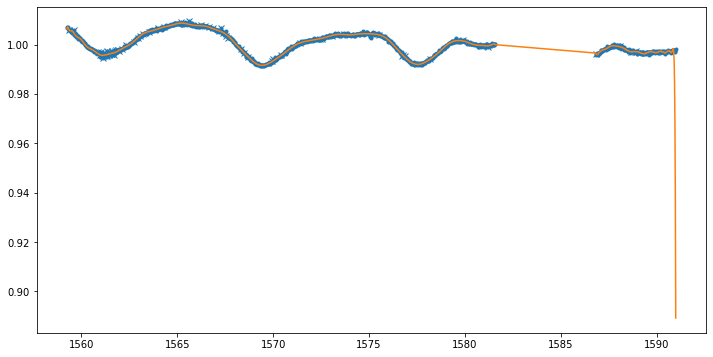

In [82]:
flux_base = []
for q in range(len(lc_data)):
    t, f, e, qual = tlist[q], flist[q], elist[q], qlist[q]
    fbase = fourier_baseline(t, f, filter_period)
    flux_base.append(fbase)
    plt.figure()
    plt.plot(t, f, '.')
    qflag = qual != 0
    plt.plot(t[qflag], f[qflag], 'x', color='C0')
    plt.plot(t, fbase, '-')

In [83]:
from scipy.ndimage import median_filter

/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_40525/2065458124.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


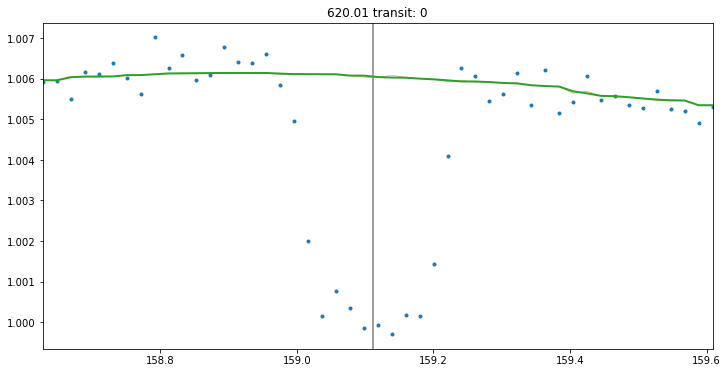

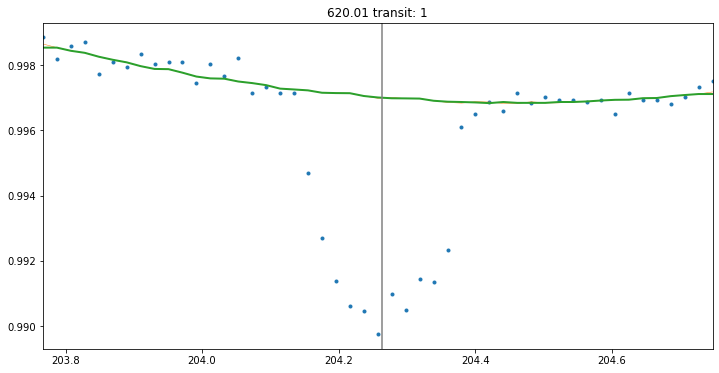

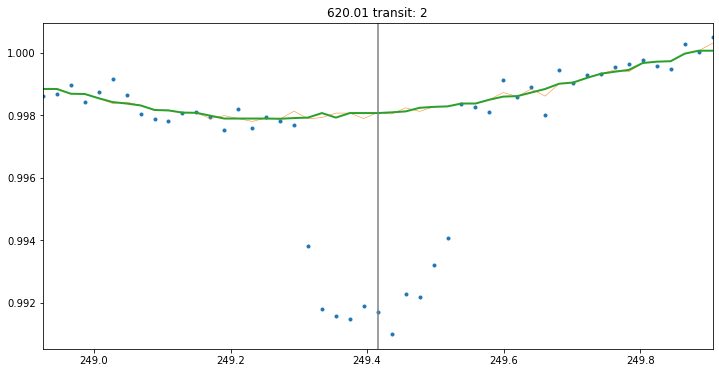

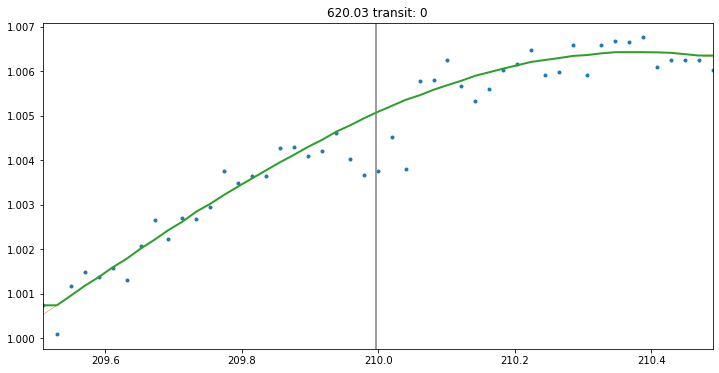

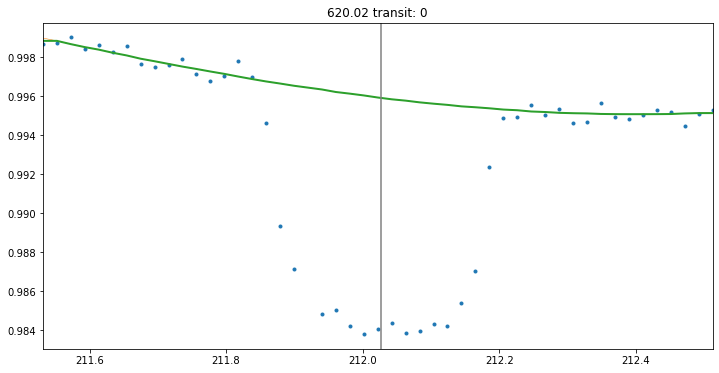

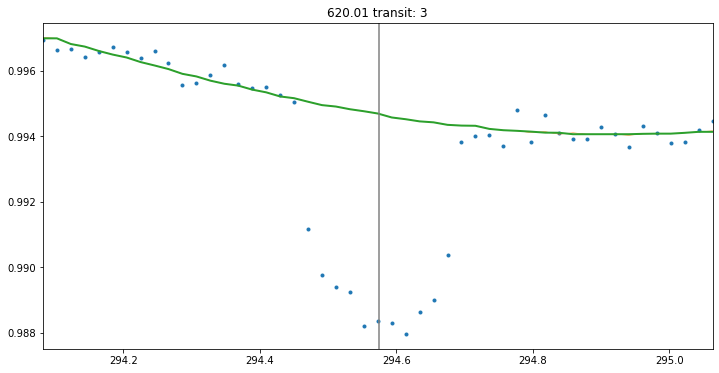

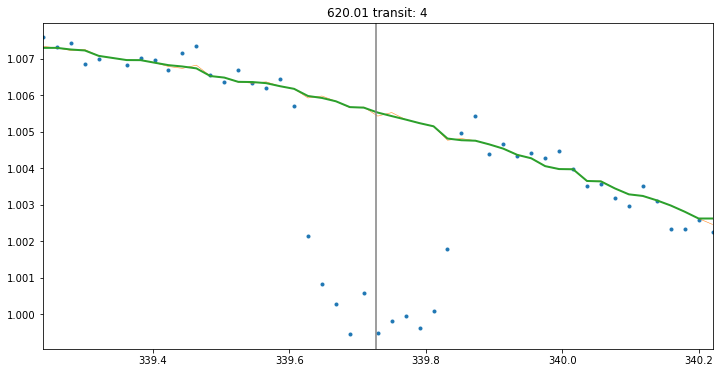

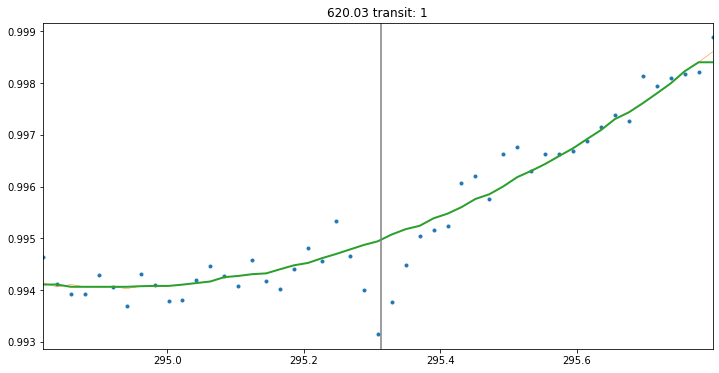

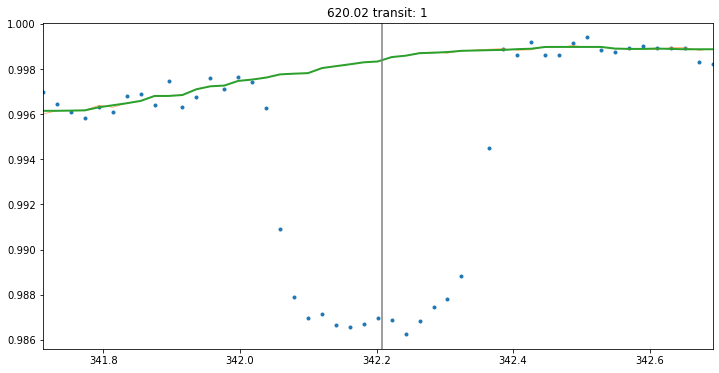

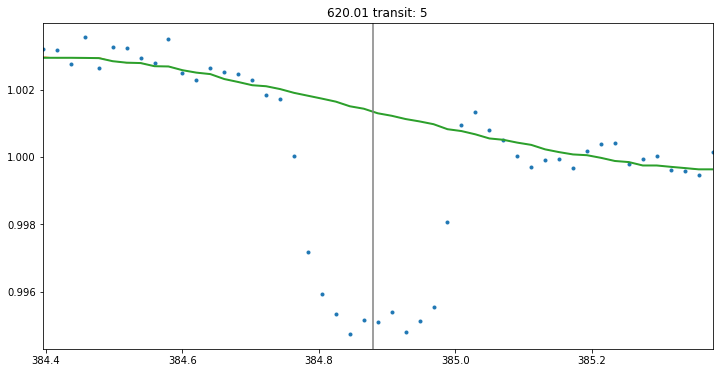

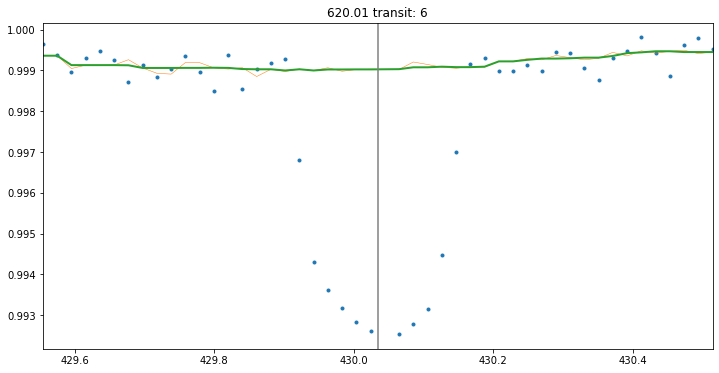

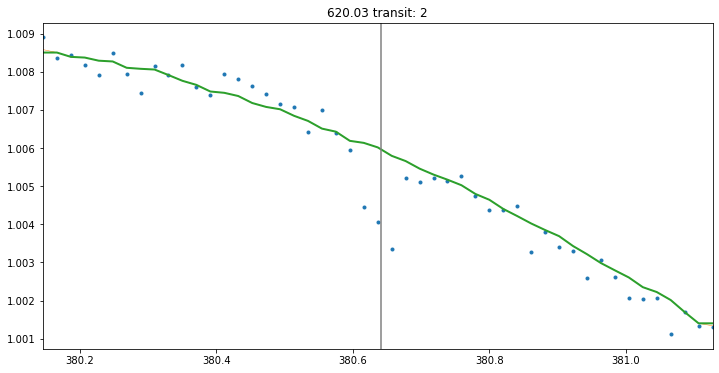

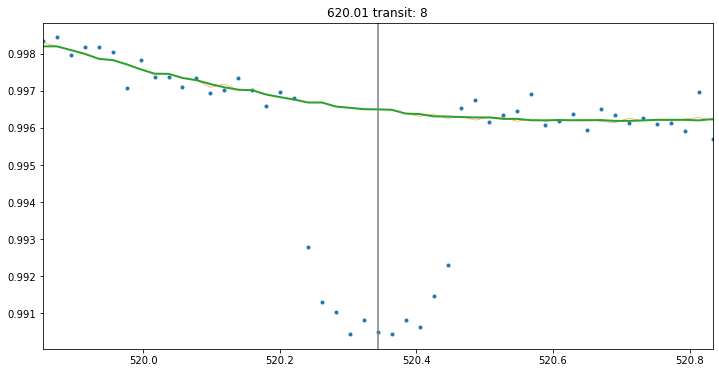

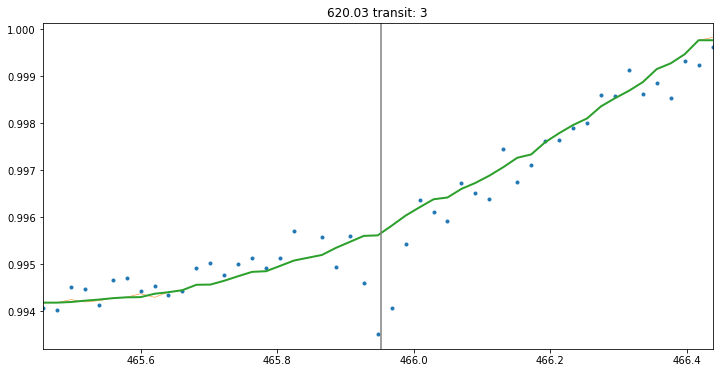

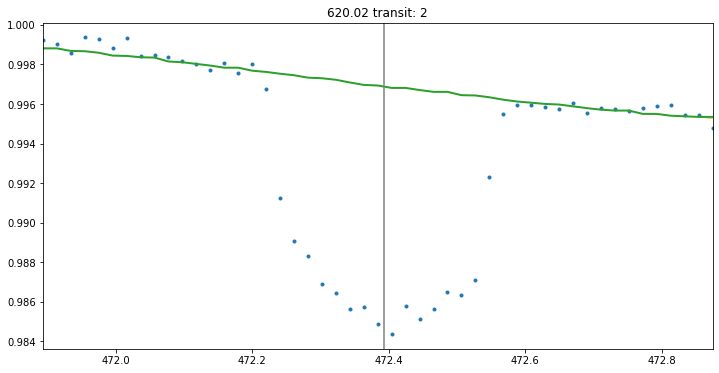

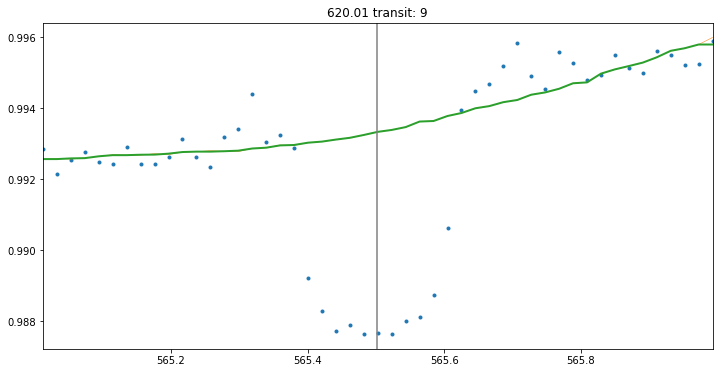

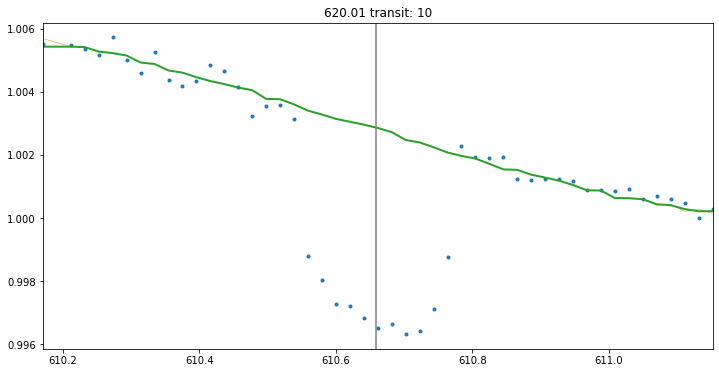

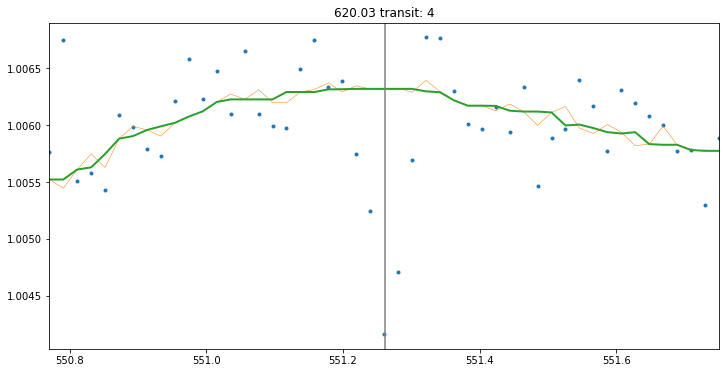

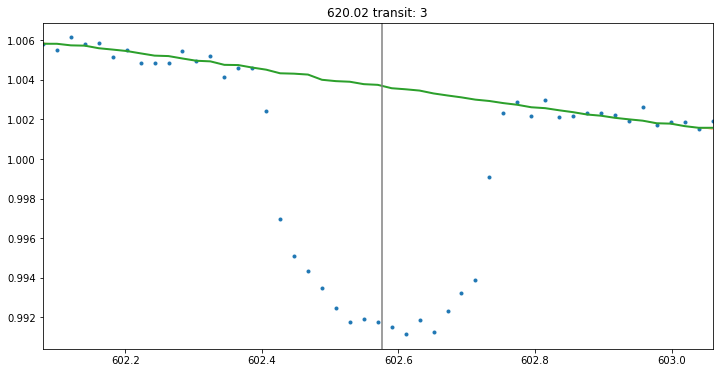

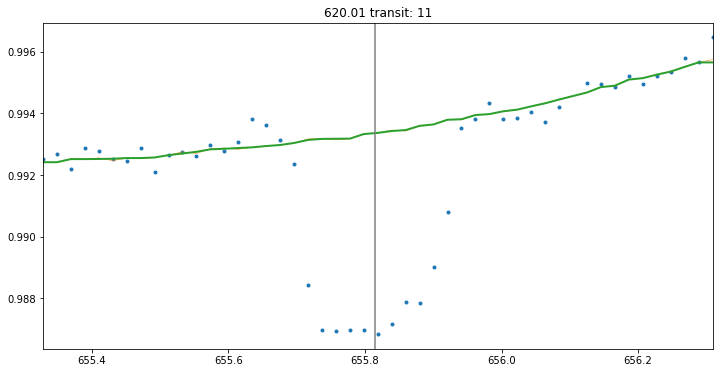

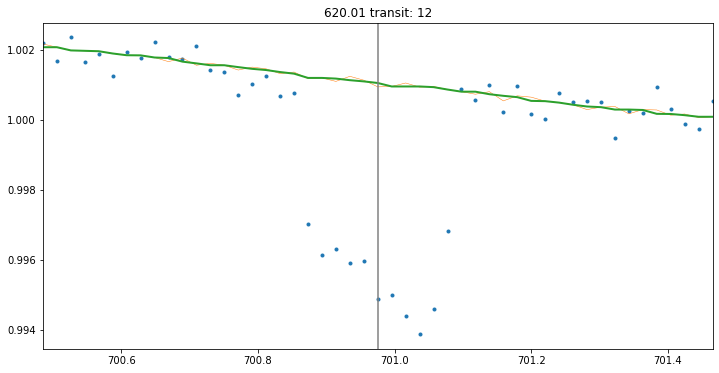

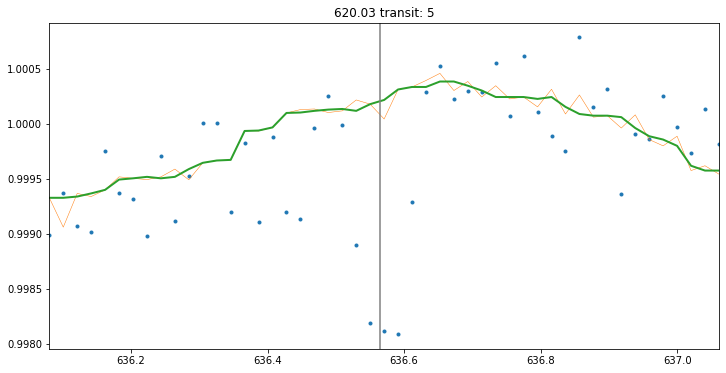

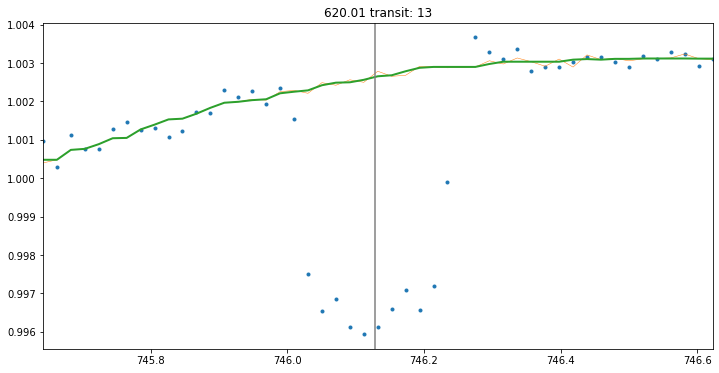

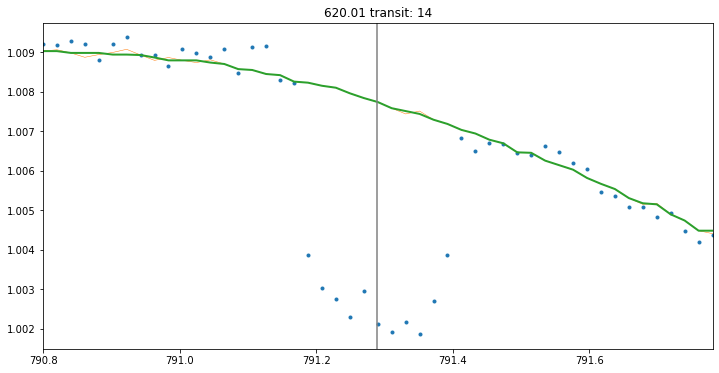

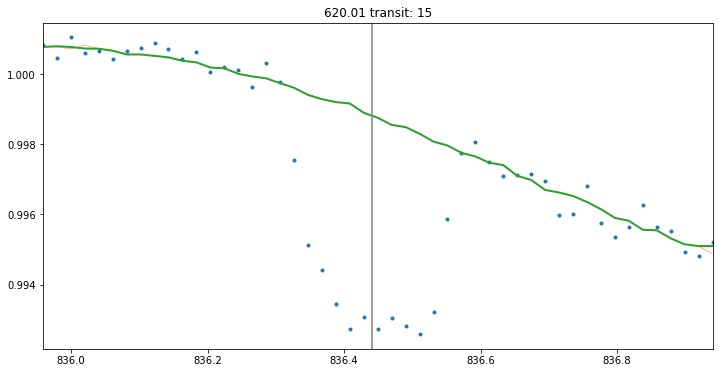

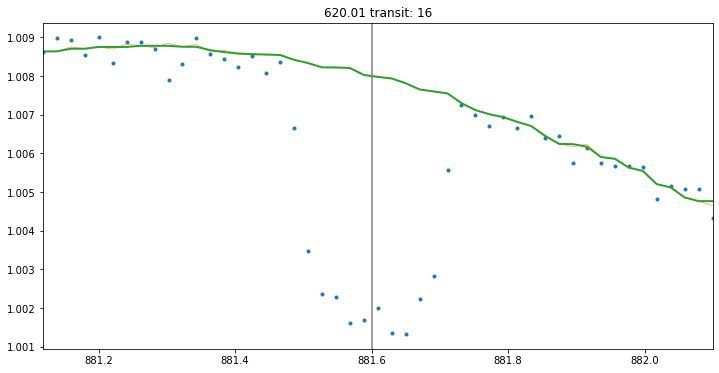

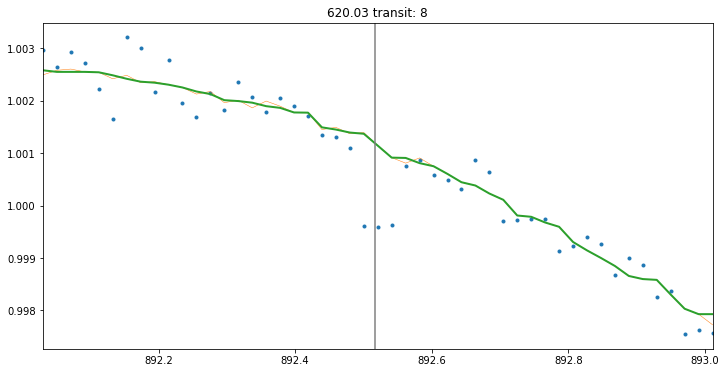

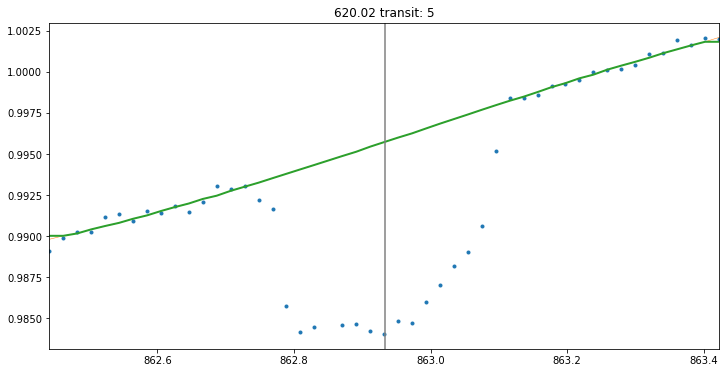

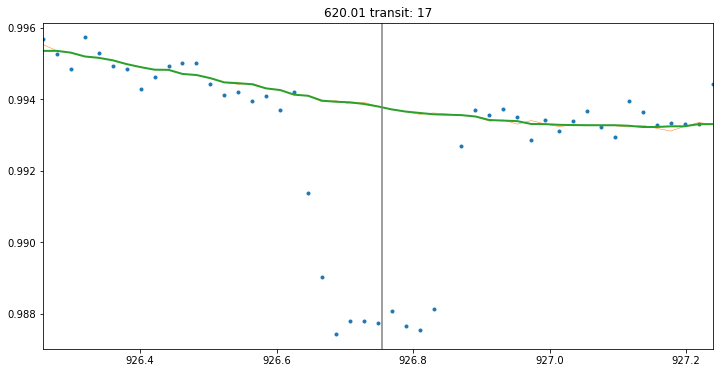

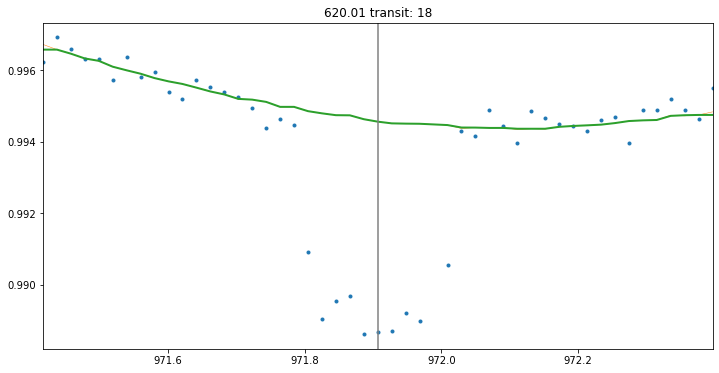

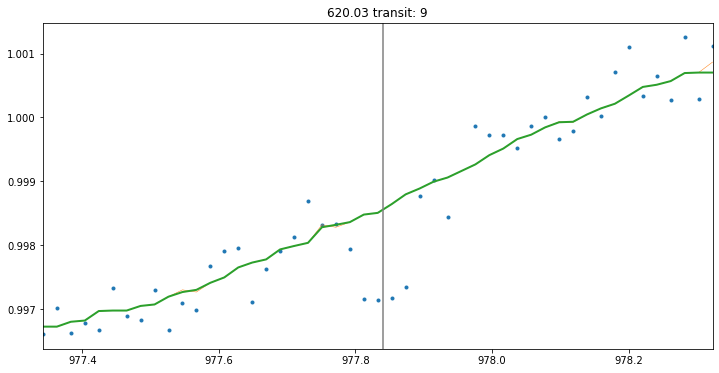

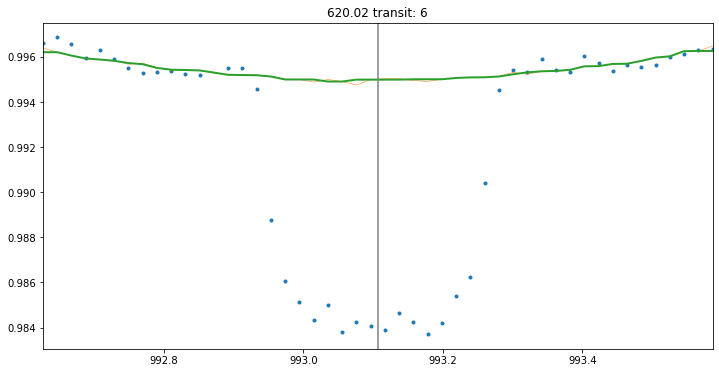

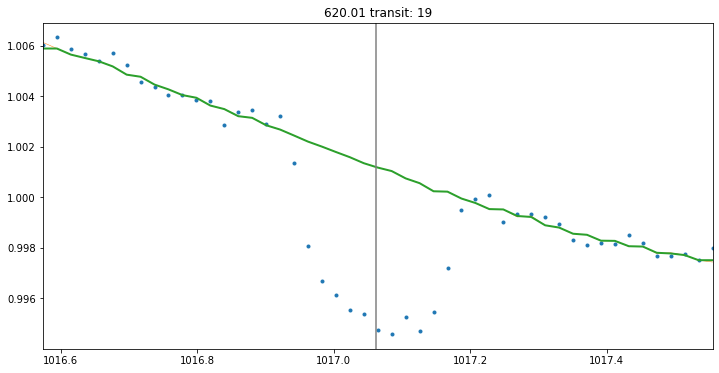

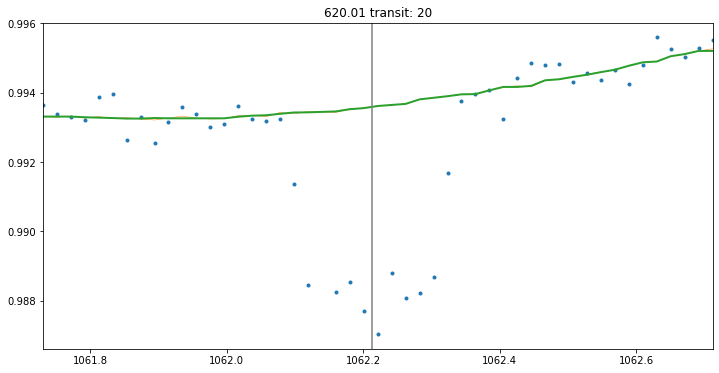

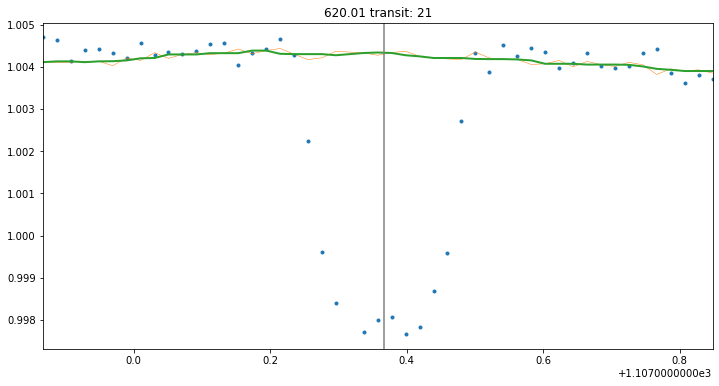

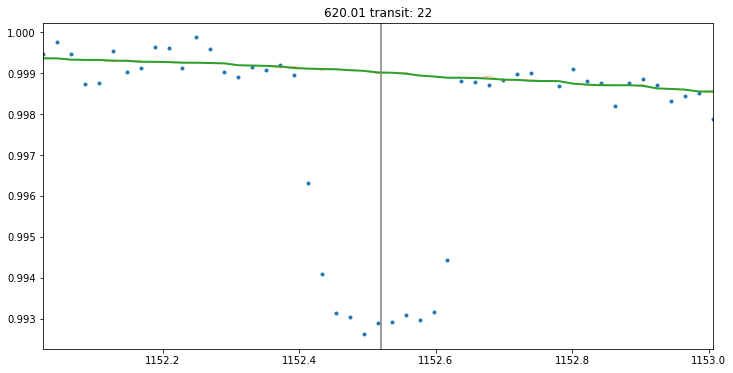

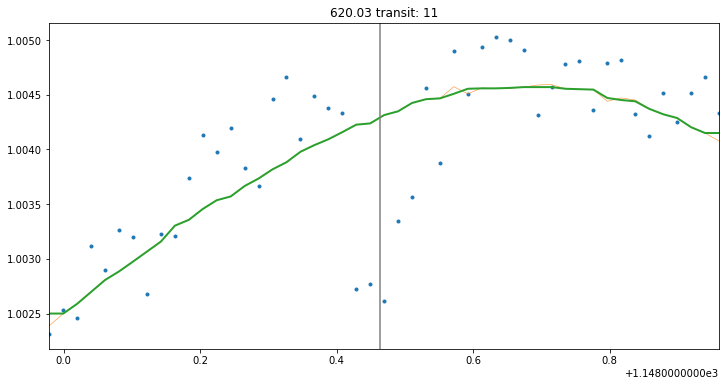

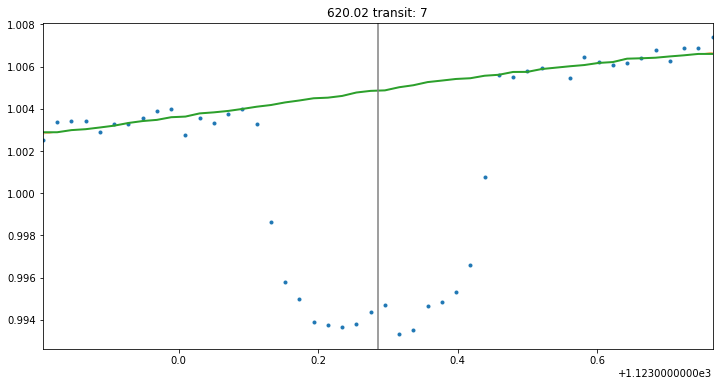

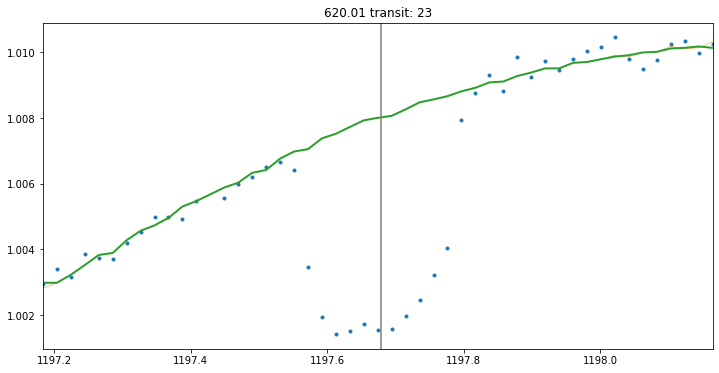

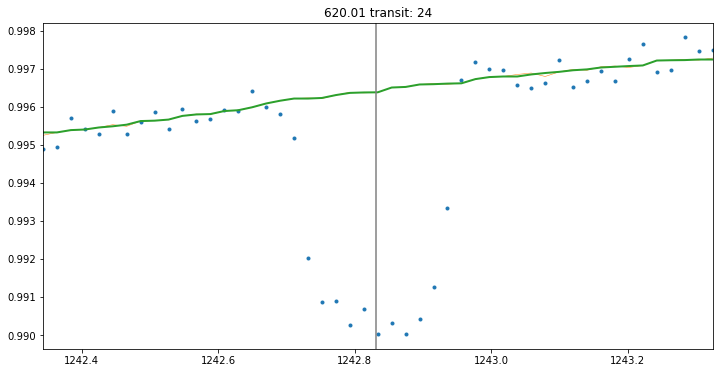

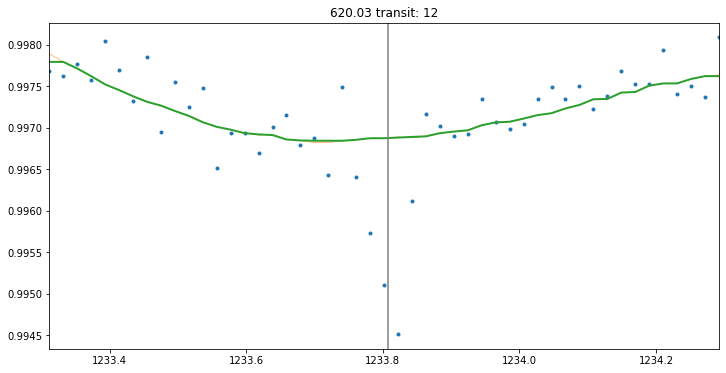

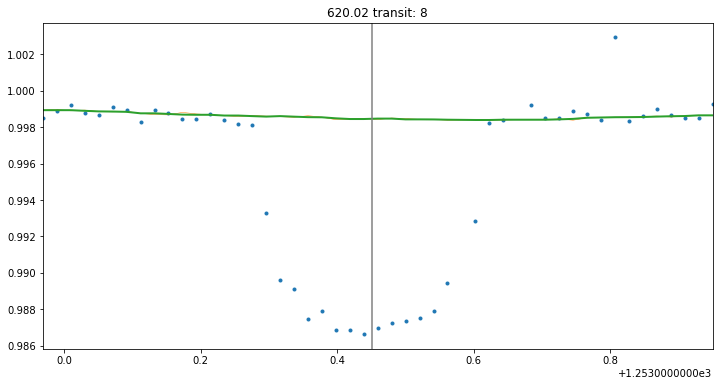

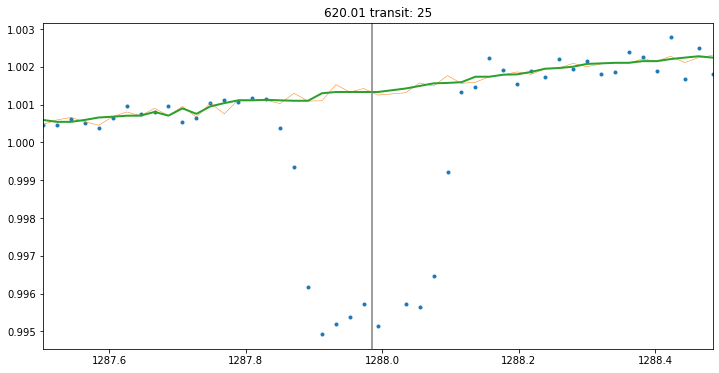

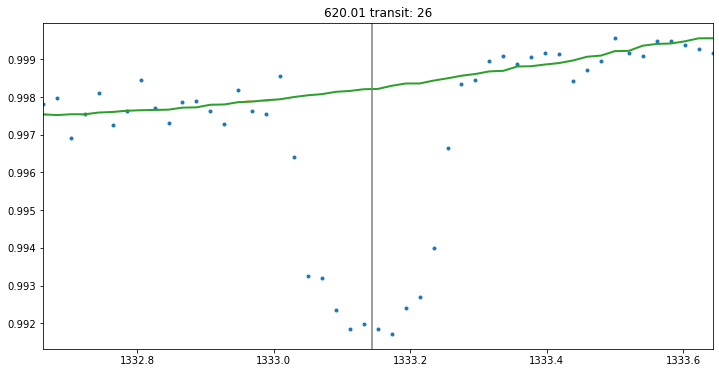

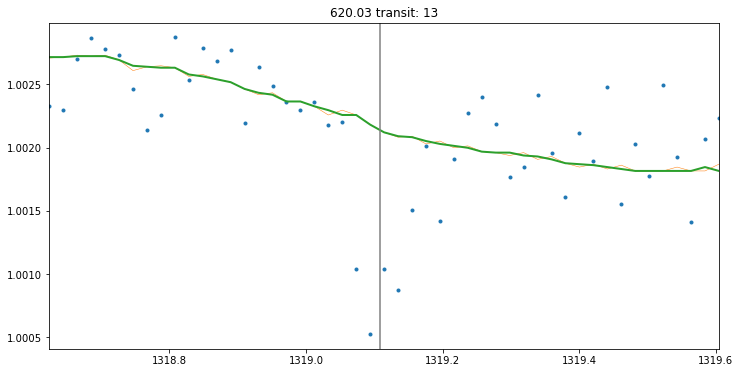

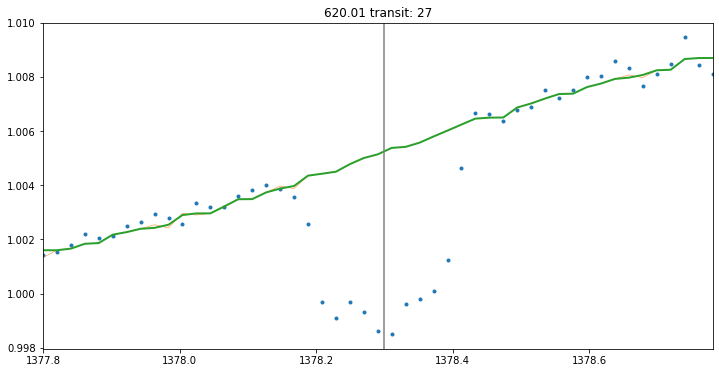

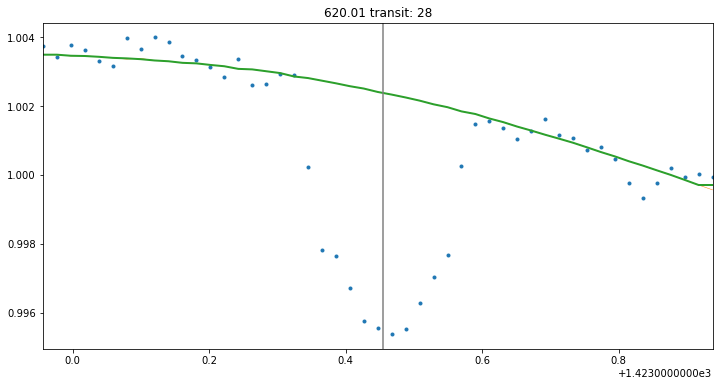

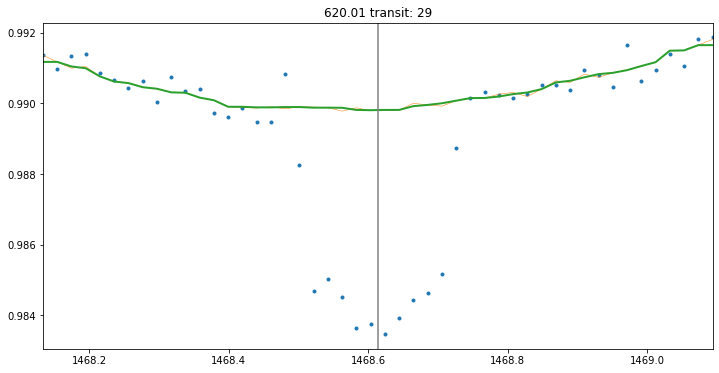

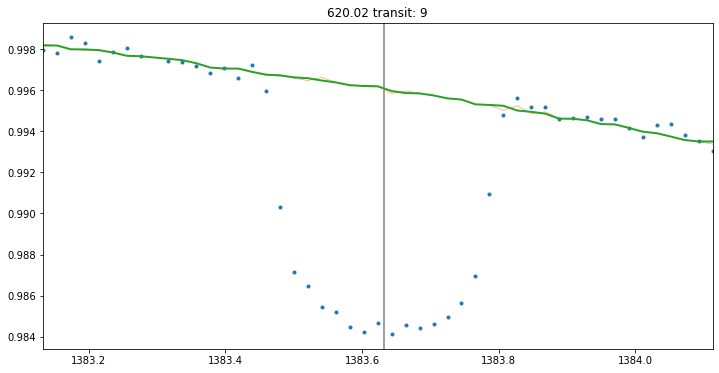

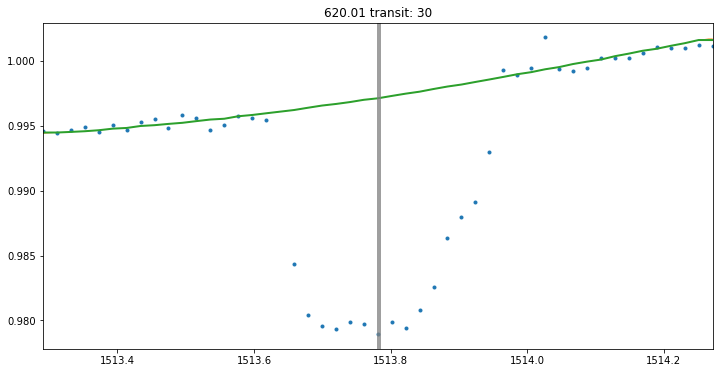

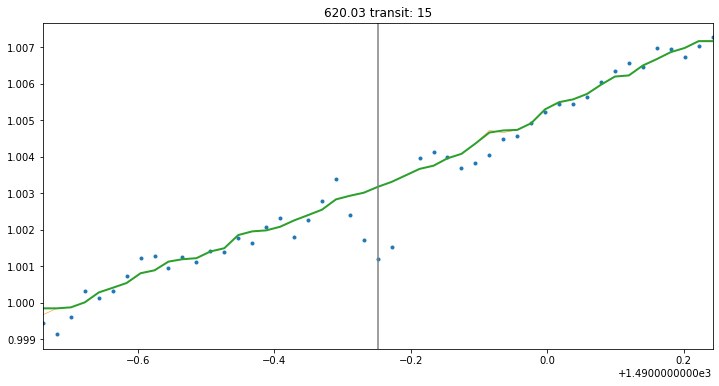

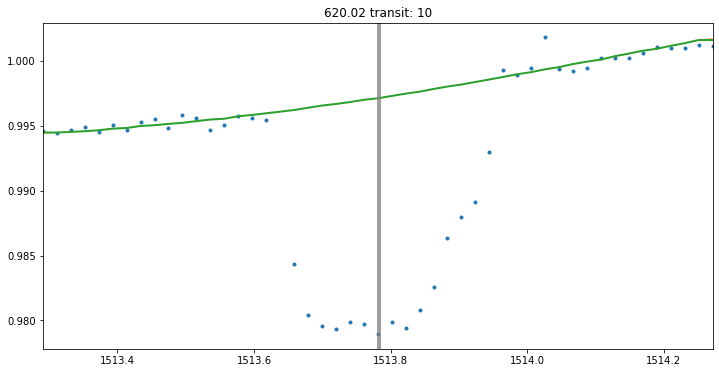

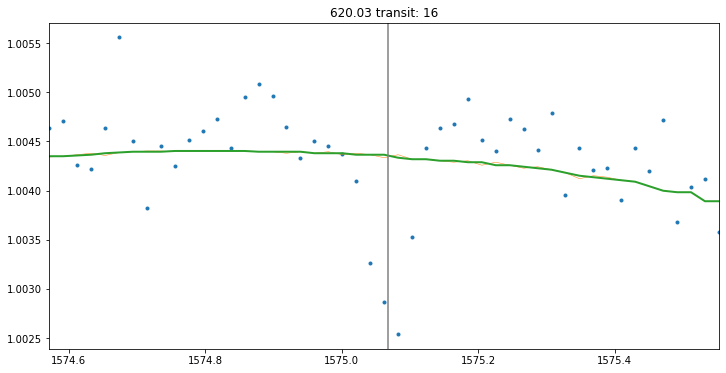

In [84]:
t_out, f_out, e_out = np.array([]), np.array([]), np.array([])
for q in range(len(lc_data)):
    t, f, e, qual = tlist[q], flist[q], elist[q], qlist[q]
    fbase = flux_base[q]
    for tc, koi, n, over in zip(dt.tc, dt.KOI, dt.N, dt.Over):
        idx = (np.abs(t-tc)<0.5)
        #idx &= (qual == 0) 
        if not np.sum(idx):
            continue
        plt.figure()
        plt.title(str(koi)+" transit: %d"%n)
        plt.xlim(np.min(t[idx]), np.max(t[idx]))
        plt.plot(t[idx], f[idx], '.')
        plt.plot(t[idx], fbase[idx], lw=0.5)
        smoothfbase = median_filter(fbase[idx], size=5)
        plt.plot(t[idx], smoothfbase, lw=2)
        for tc in dt.tc:
            plt.axvline(x=tc, color='gray')
        if not over:
            t_out = np.r_[t_out, t[idx]]
            f_out = np.r_[f_out, f[idx]/smoothfbase]
            e_out = np.r_[e_out, e[idx]/smoothfbase]

In [85]:
df_lc = pd.DataFrame(data={"time": t_out, "flux": f_out, "error": e_out}).sort_values("time").reset_index(drop=True)

In [19]:
df_lc

time      flux     error
0      158.628017  0.999973  0.000288
1      158.648451  0.999997  0.000288
2      158.668886  0.999478  0.000288
3      158.689320  1.000145  0.000288
4      158.709754  1.000079  0.000288
...           ...       ...       ...
2467  1575.470984  1.000730  0.000296
2468  1575.491418  0.999733  0.000296
2469  1575.511852  1.000111  0.000296
2470  1575.532286  1.000231  0.000296
2471  1575.552720  0.999695  0.000296

[2472 rows x 3 columns]

In [20]:
df_lc.to_csv("lc_no_overlap.txt", index=False)

## short cadence

In [43]:
filter_period = 1.5

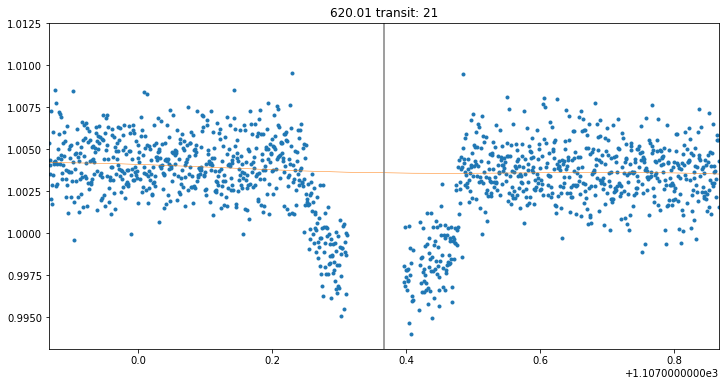

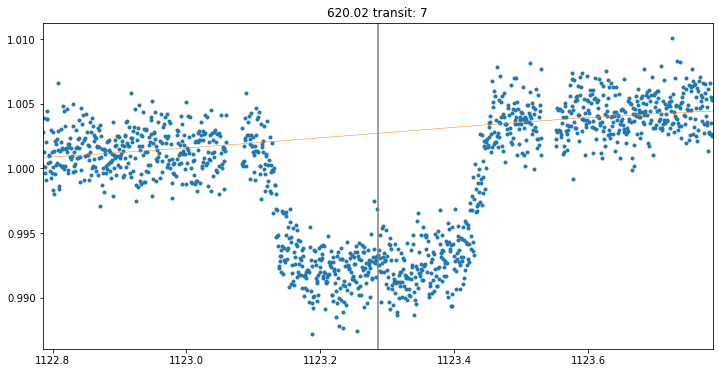

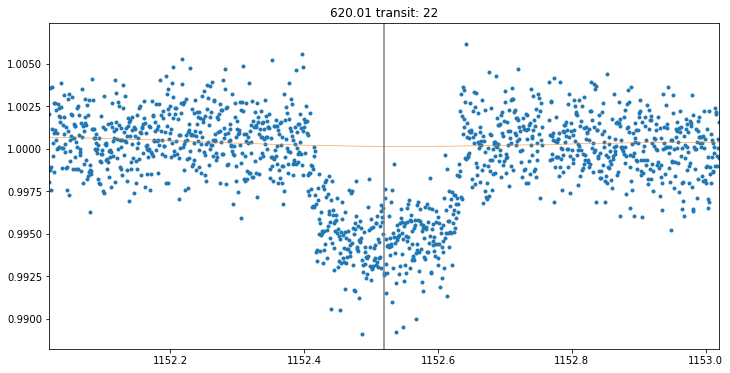

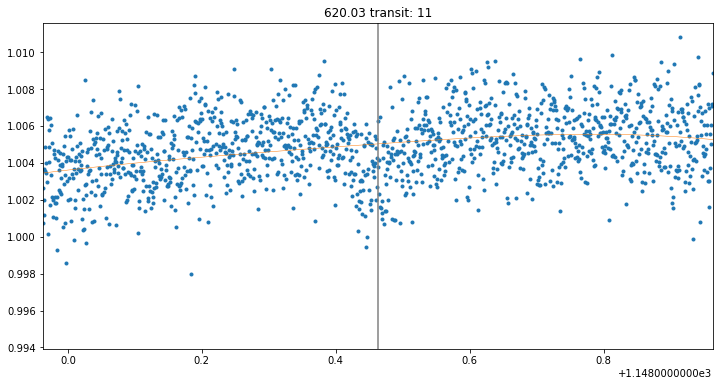

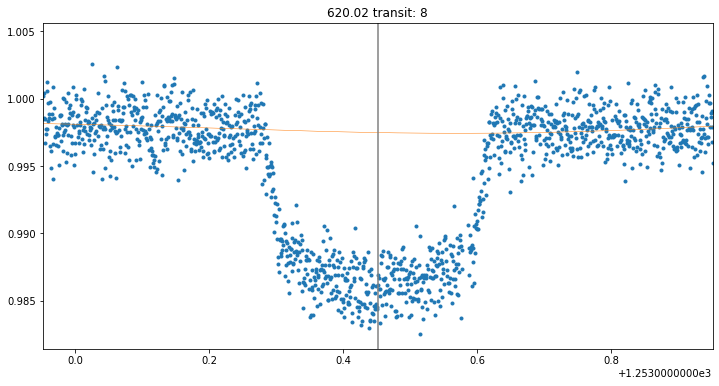

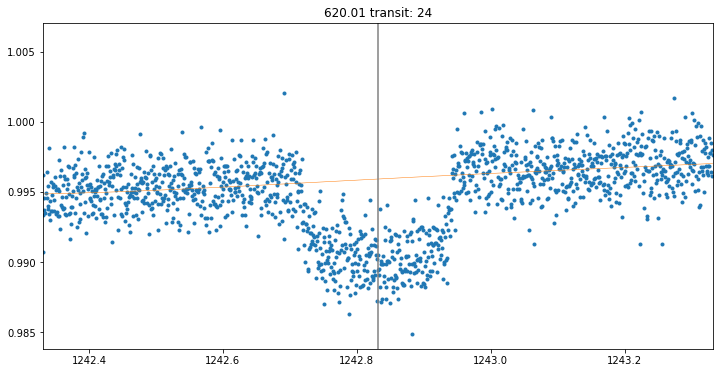

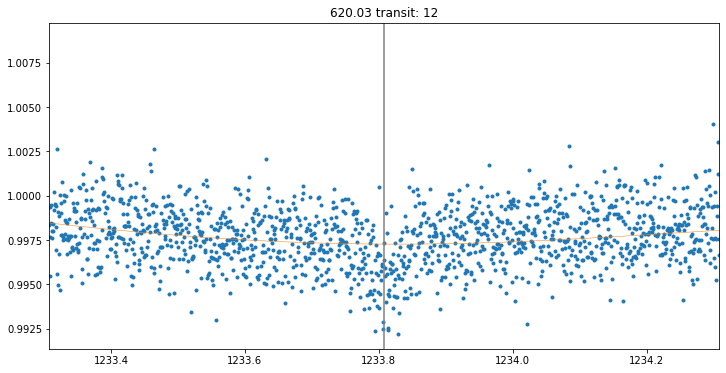

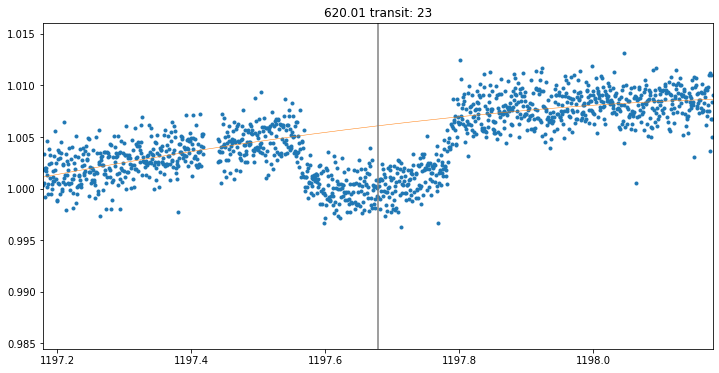

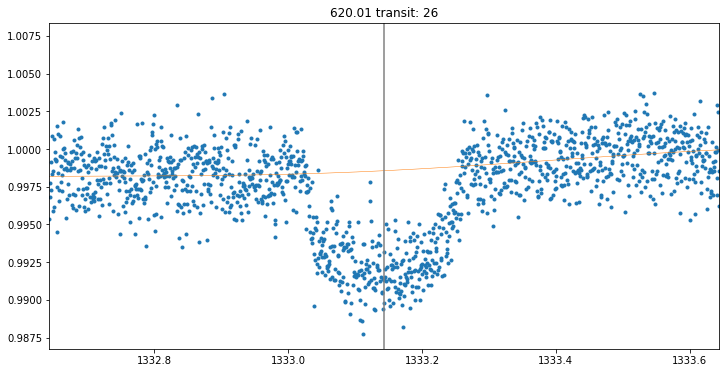

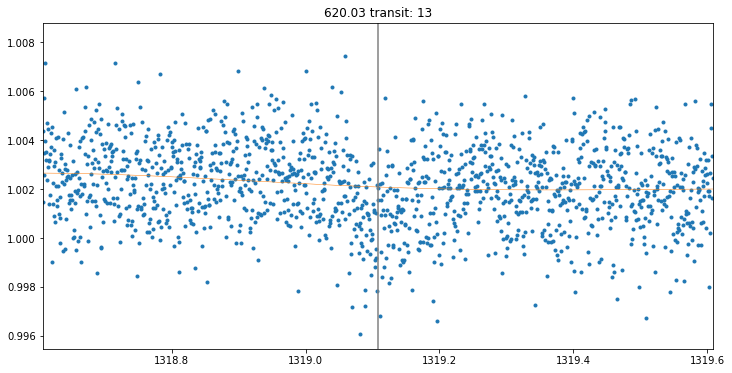

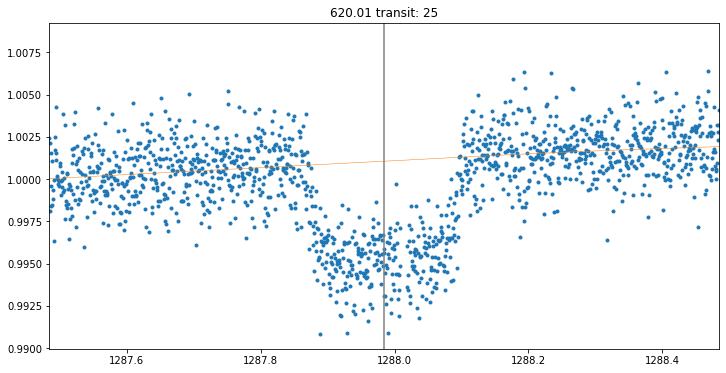

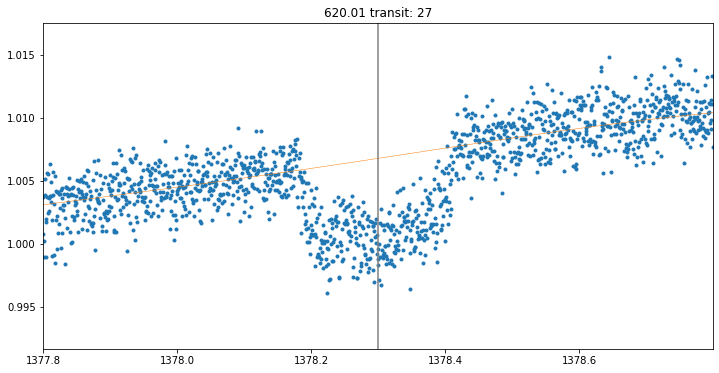

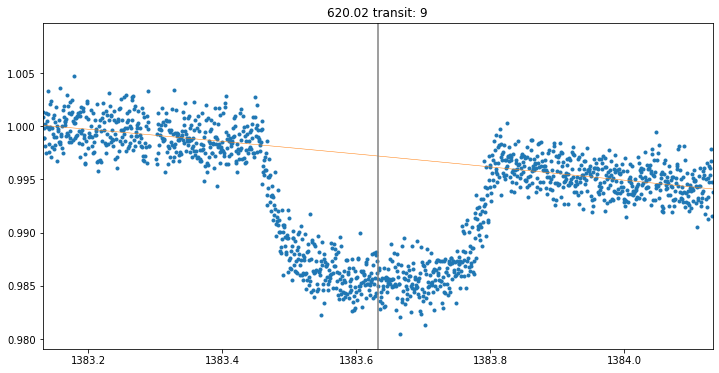

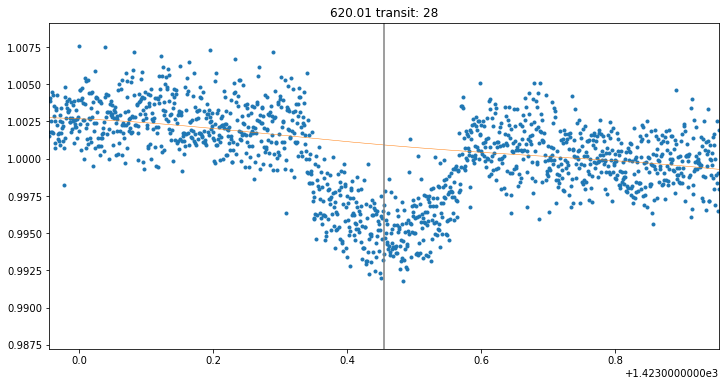

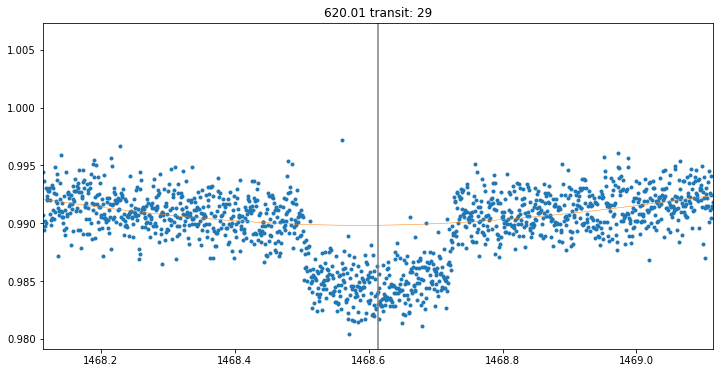

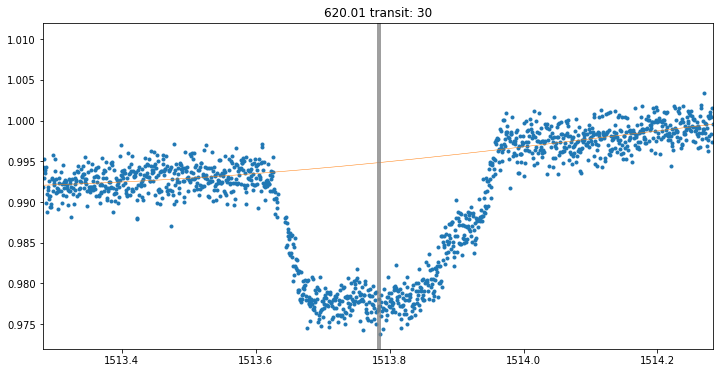

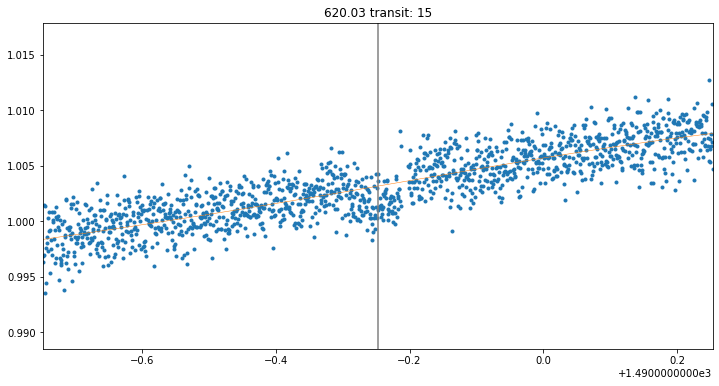

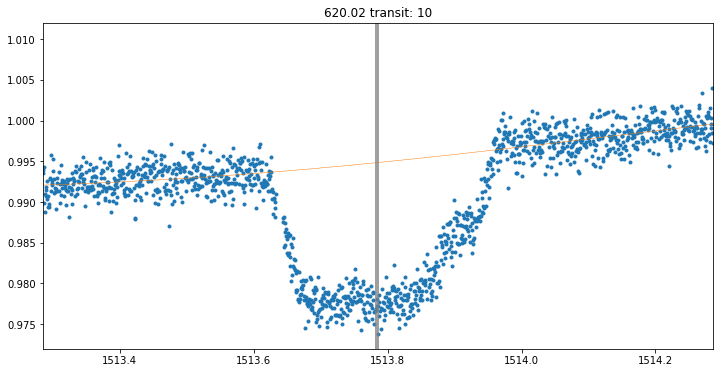

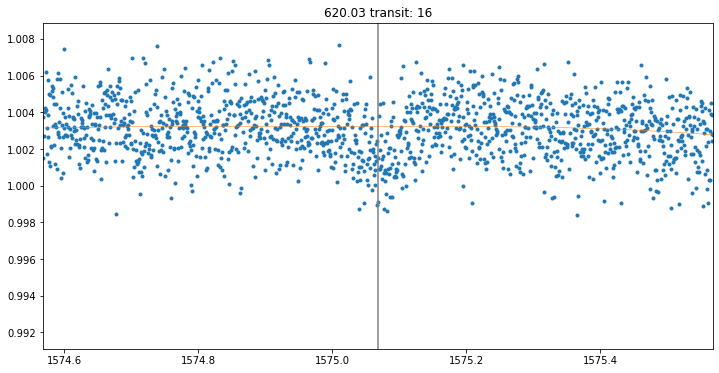

In [75]:
t_out, f_out, e_out = np.array([]), np.array([]), np.array([])
for q in range(len(sc_data)):
    #t, f, e, qual = tlist[q], flist[q], elist[q], qlist[q]
    t, f, e, qual = lc_quarter(sc_data, q)
    #fbase = flux_base[q]
    for tc, koi, n, over in zip(dt.tc, dt.KOI, dt.N, dt.Over):
        idx = (np.abs(t-tc)<filter_period)
        idx &= (qual == 0) 
        if not np.sum(idx):
            continue
        plt.figure()
        plt.title(str(koi)+" transit: %d"%n)
        plt.xlim(np.min(t[idx]), np.max(t[idx]))
        plt.xlim(tc-0.5, tc+0.5)
        plt.plot(t[idx], f[idx], '.')
        fbase = fourier_baseline(t[idx], f[idx], filter_period)
        plt.plot(t[idx], fbase, lw=0.5)
        smoothfbase = fbase#median_filter(fbase[idx], size=5)
        #plt.plot(t[idx], smoothfbase, lw=2)
        idxcut = np.abs(t[idx]-tc)<0.5
        for tc in dt.tc:
            plt.axvline(x=tc, color='gray')
        if np.sum(idxcut) and (not over):
            t_out = np.r_[t_out, t[idx][idxcut]]
            f_out = np.r_[f_out, f[idx][idxcut]/smoothfbase[idxcut]]
            e_out = np.r_[e_out, e[idx][idxcut]/smoothfbase[idxcut]]

In [77]:
df_sc = pd.DataFrame(data={"time": t_out, "flux": f_out, "error": e_out}).sort_values("time").reset_index(drop=True)

In [79]:
df_sc.to_csv("sc_no_overlap.txt", index=False)

/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_40525/3021889396.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


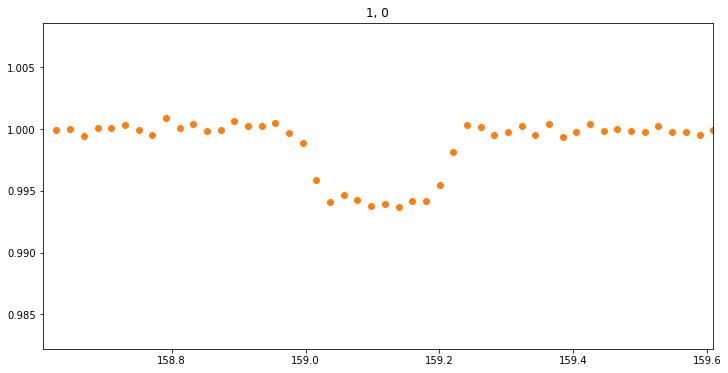

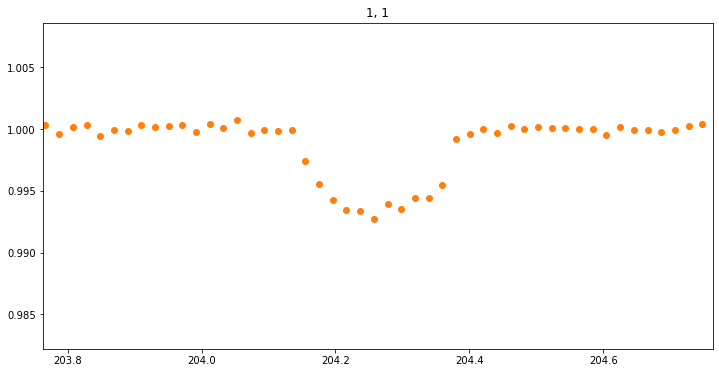

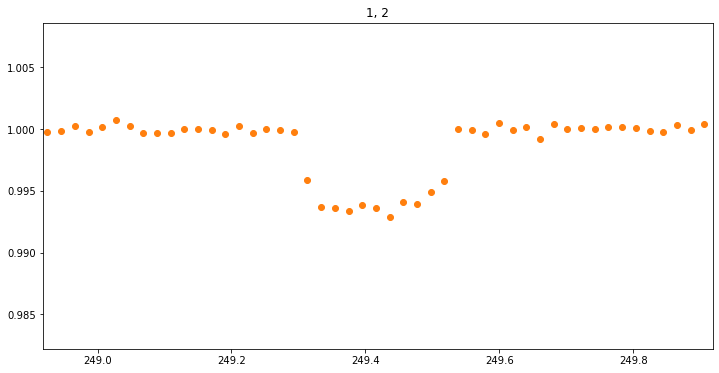

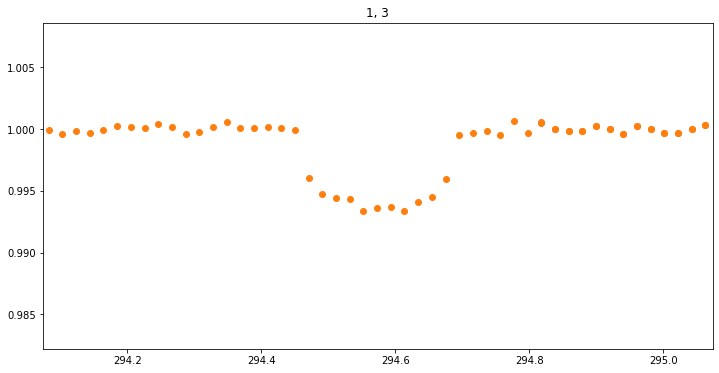

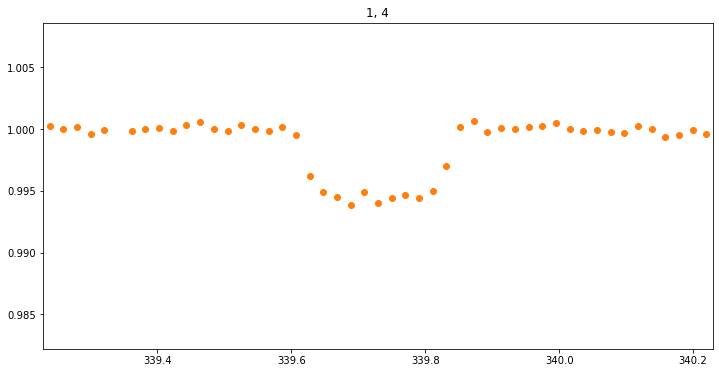

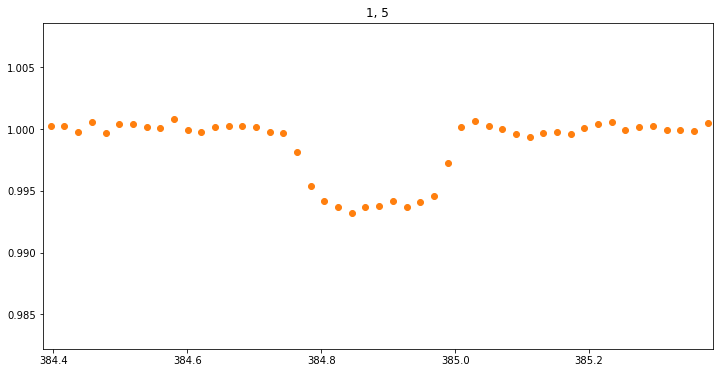

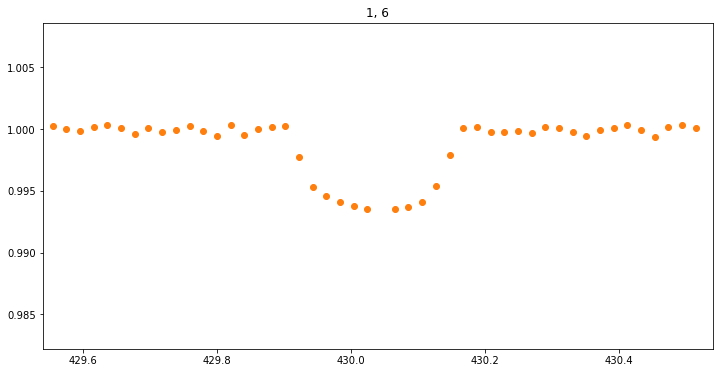

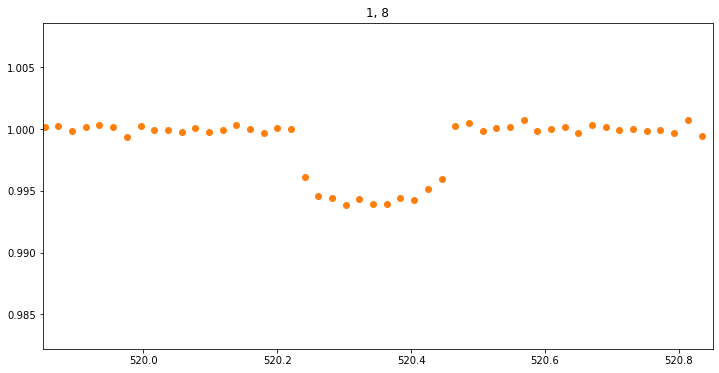

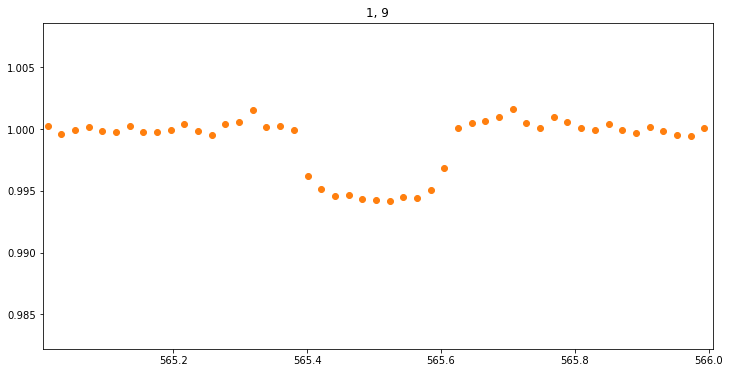

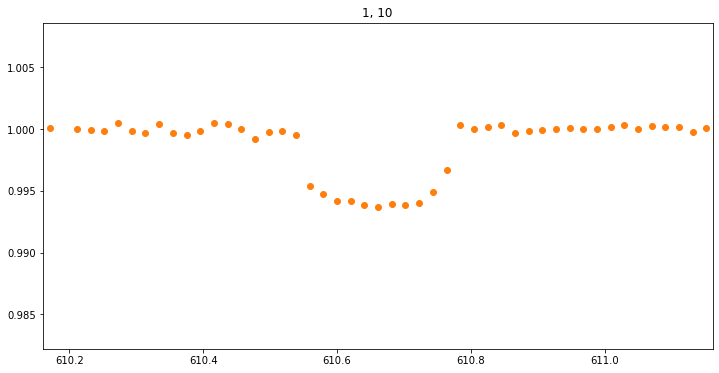

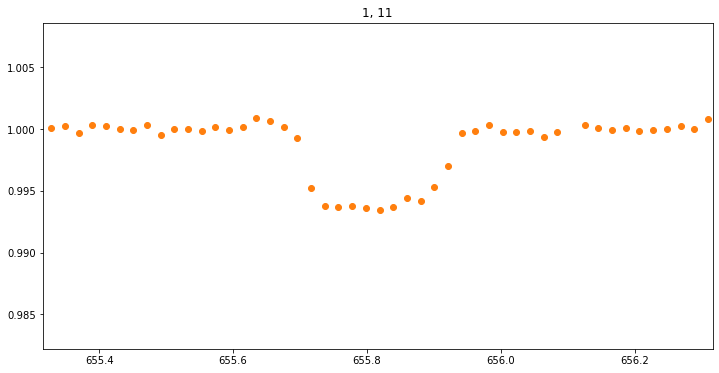

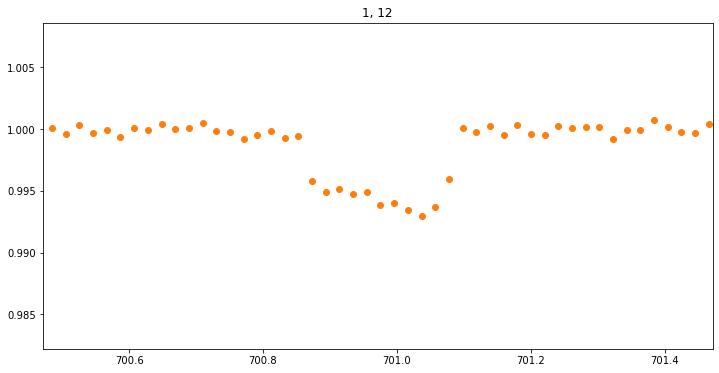

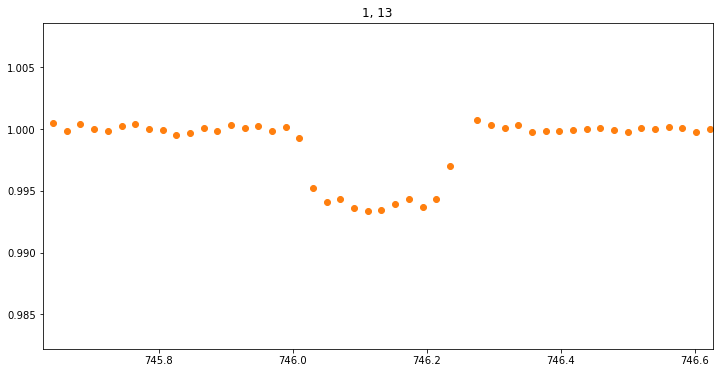

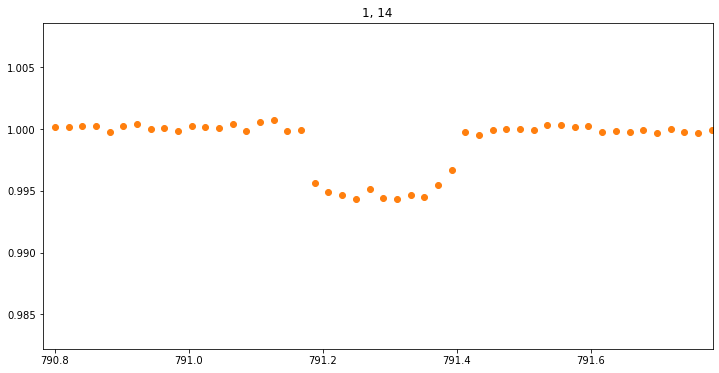

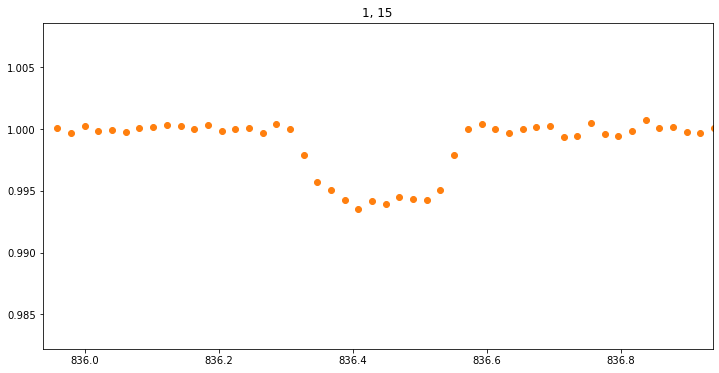

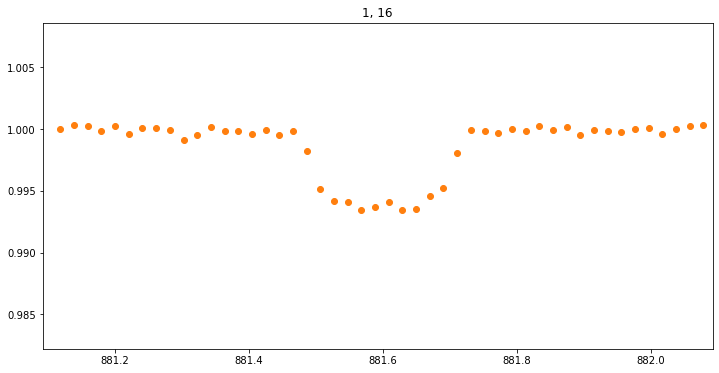

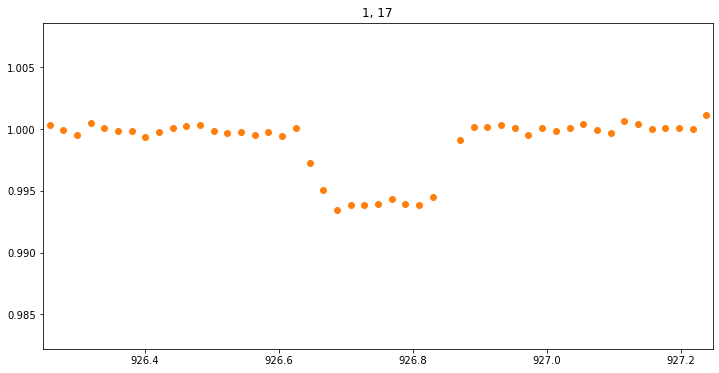

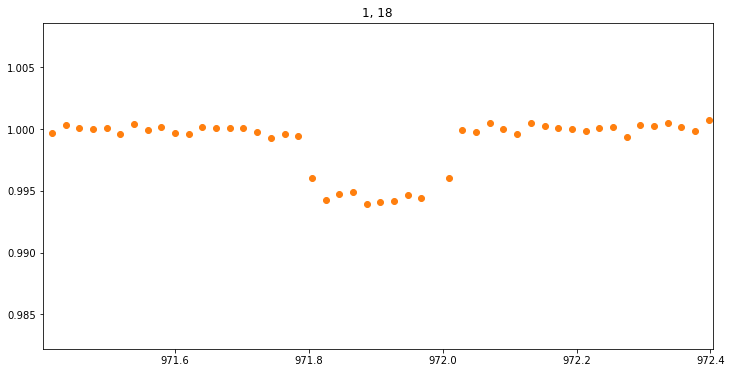

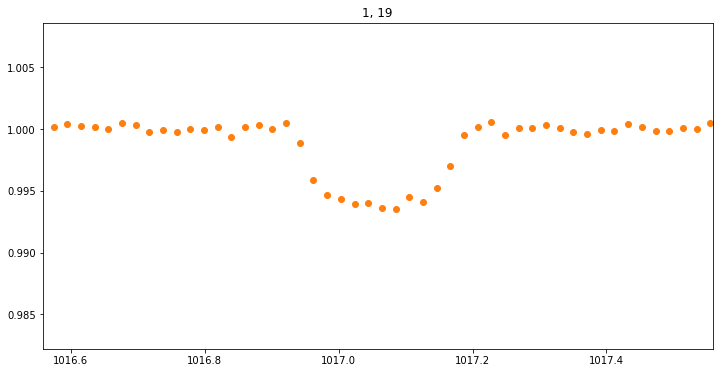

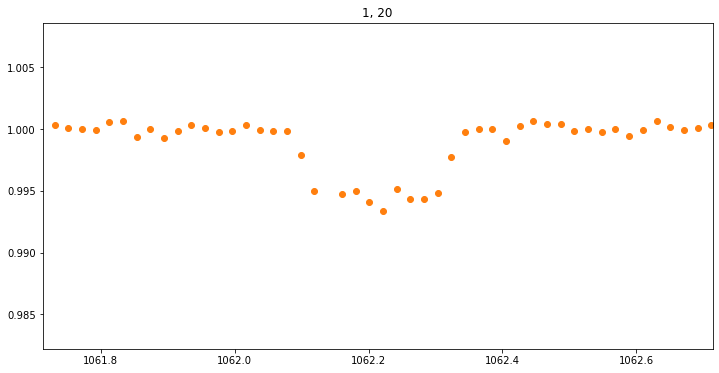

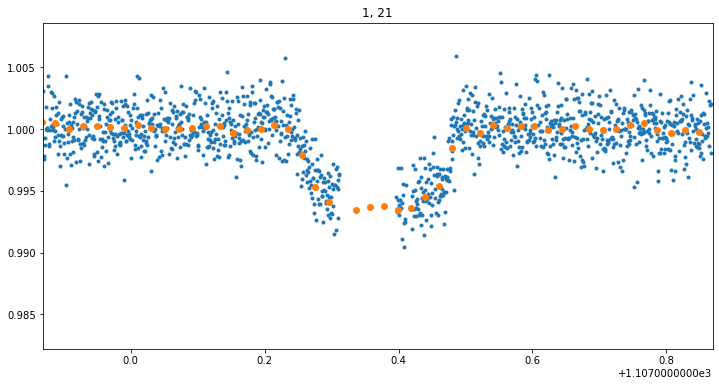

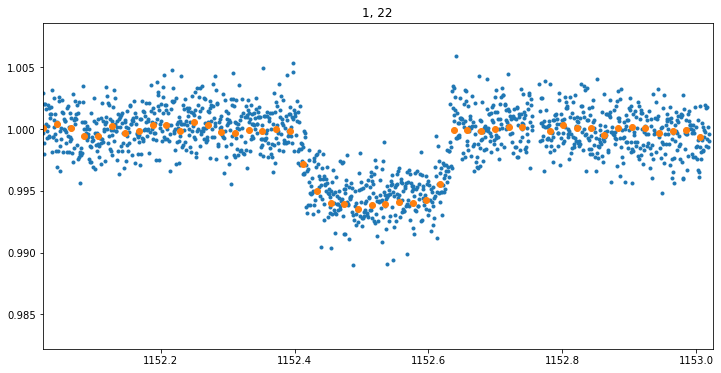

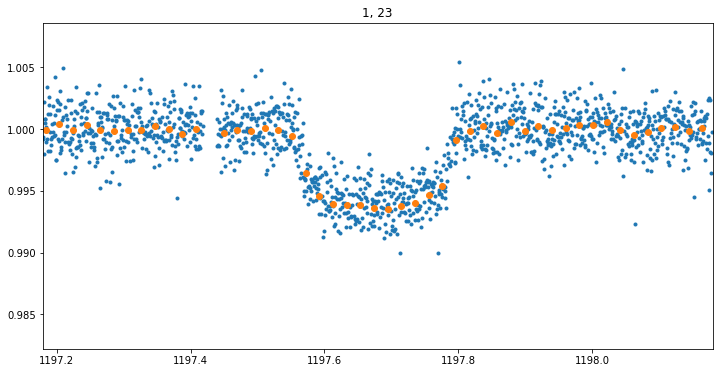

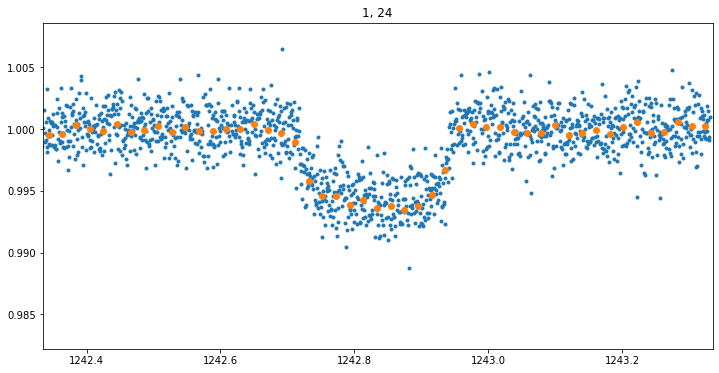

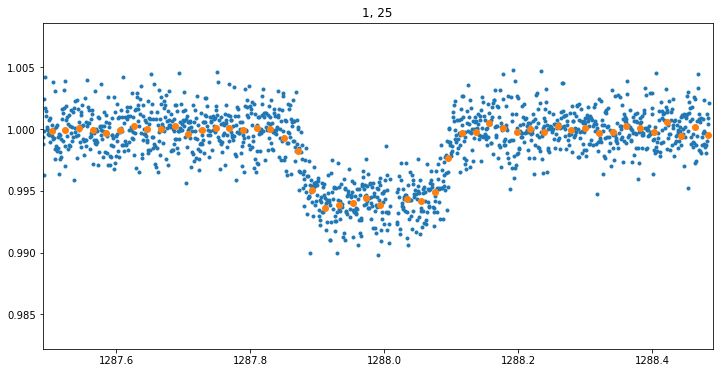

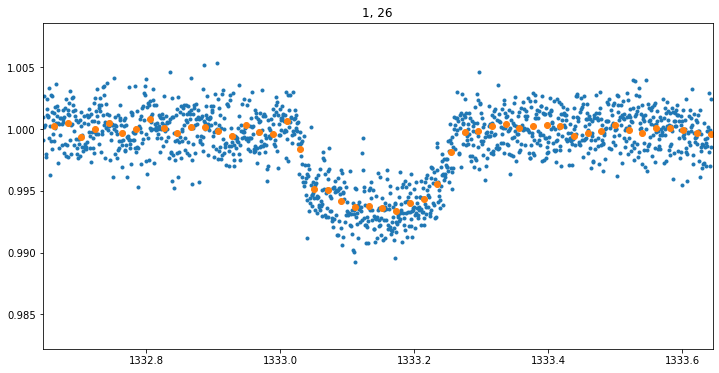

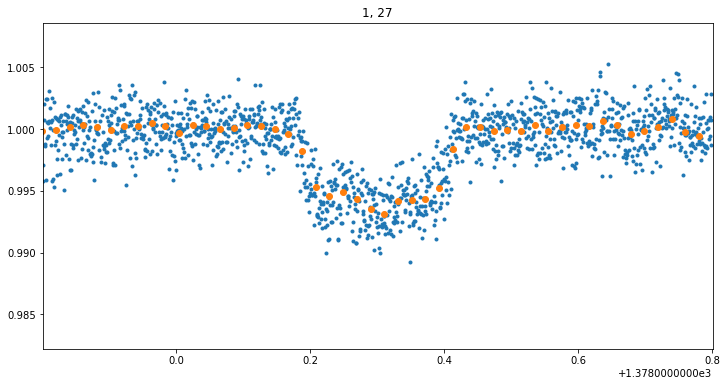

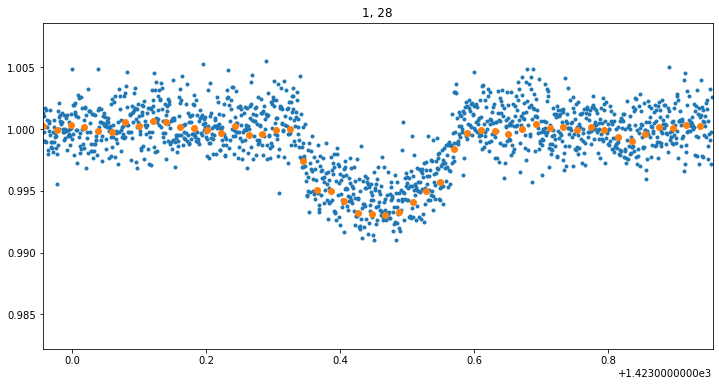

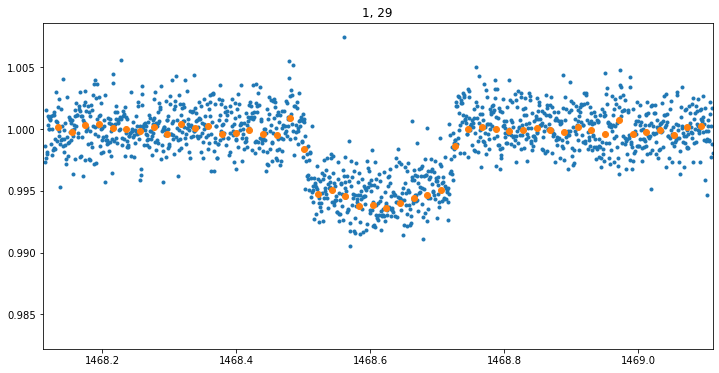

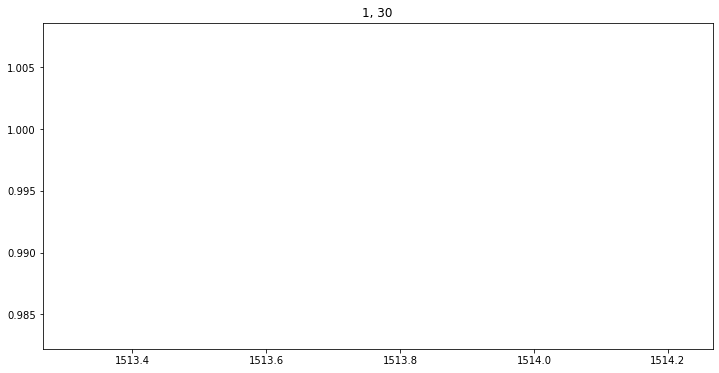

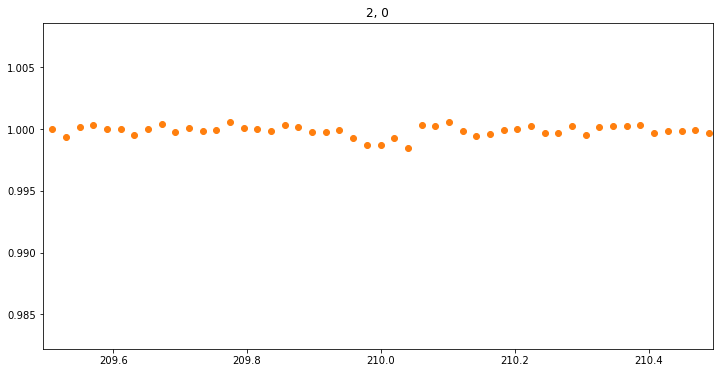

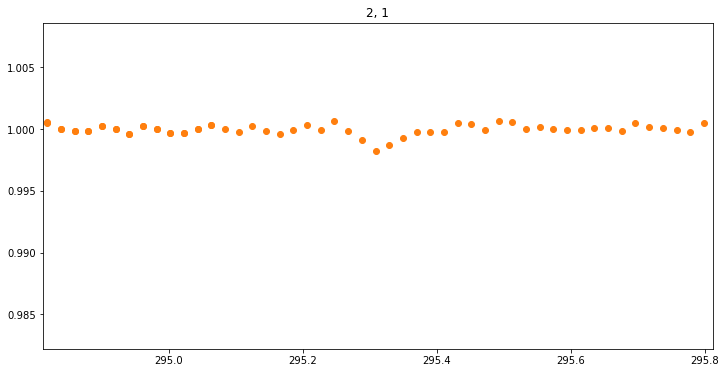

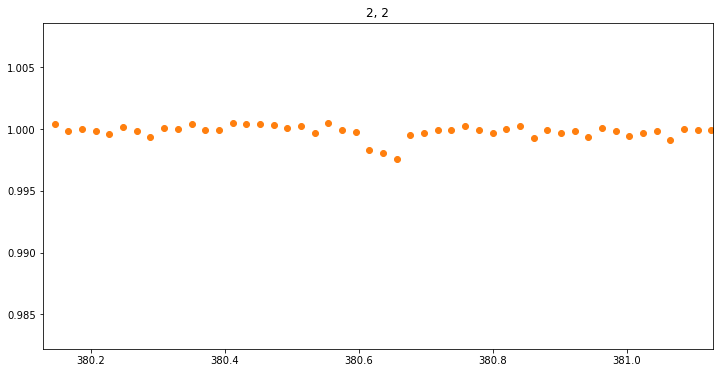

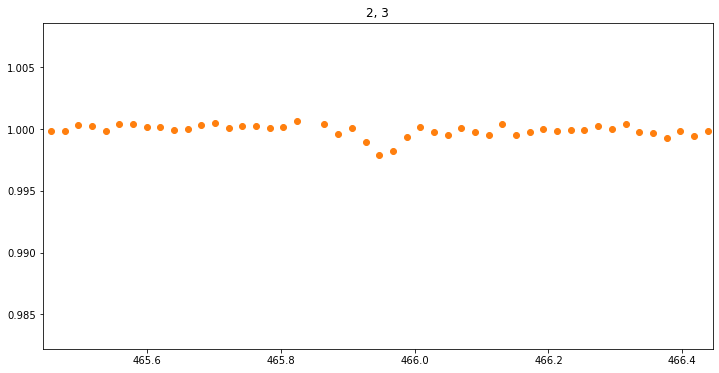

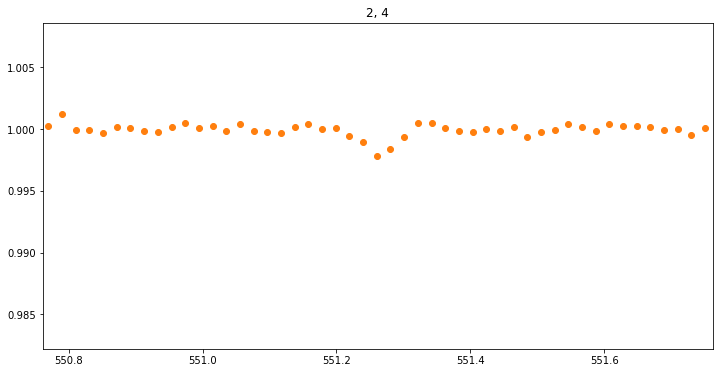

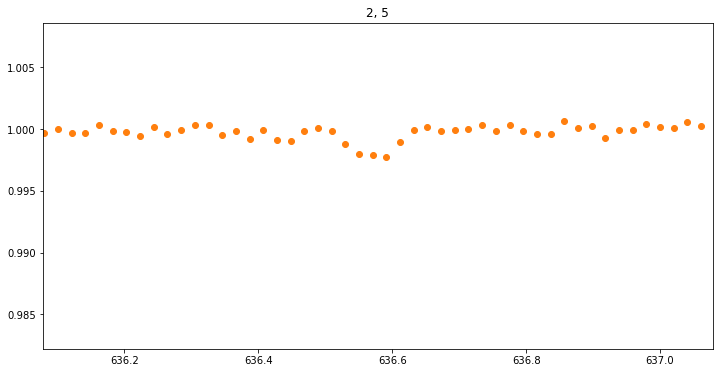

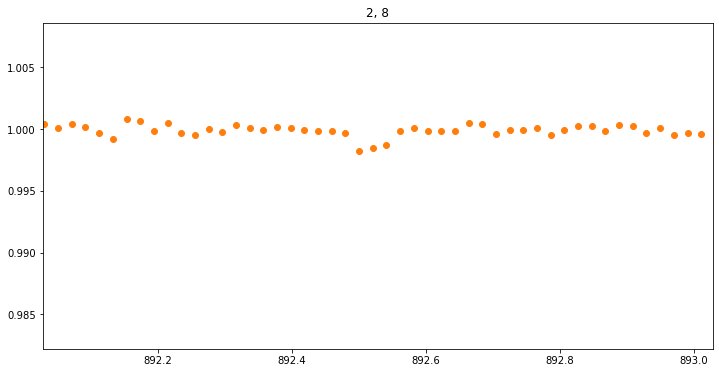

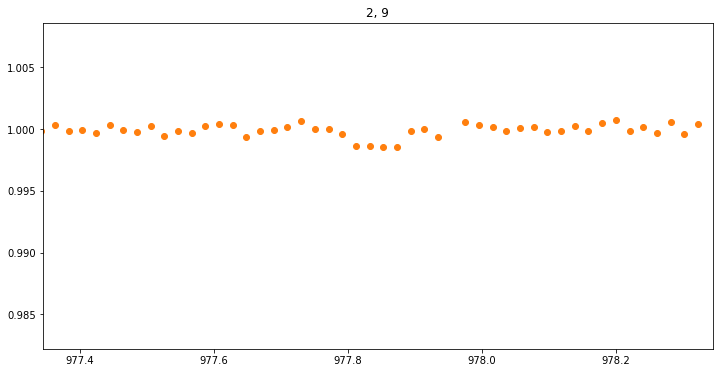

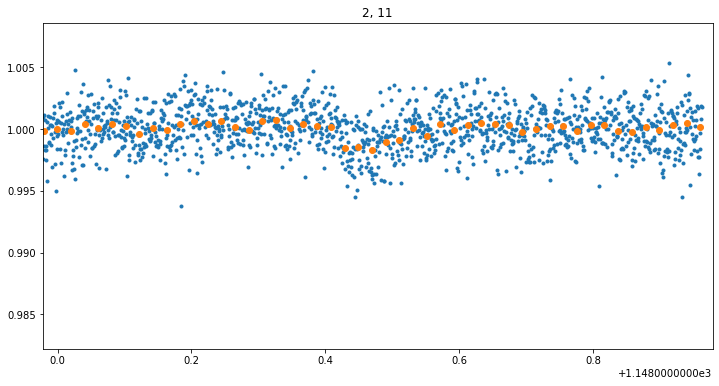

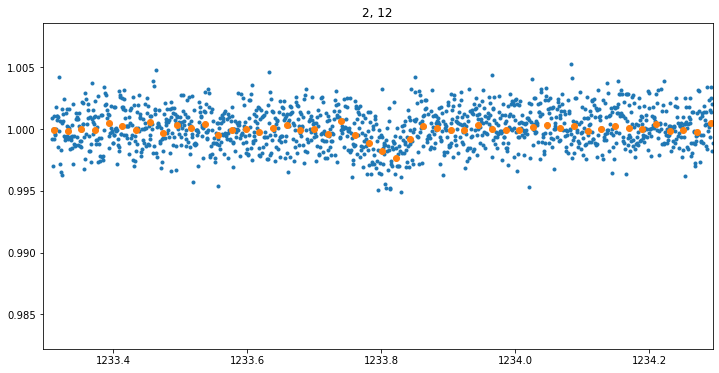

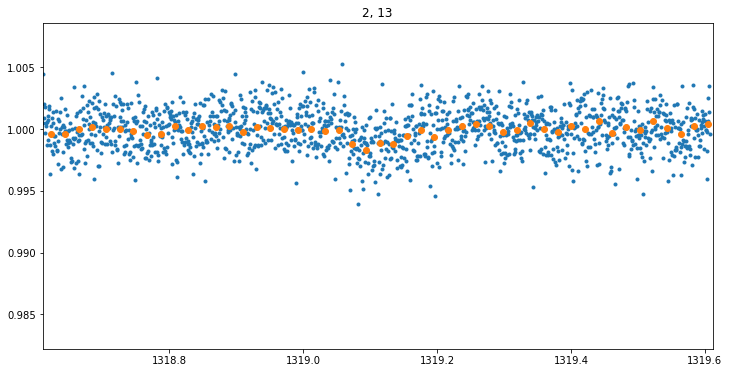

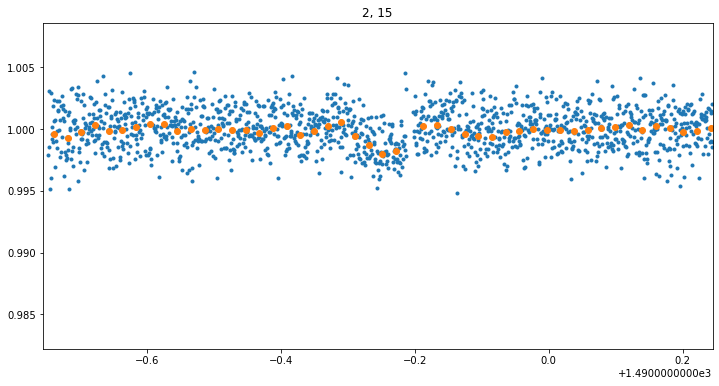

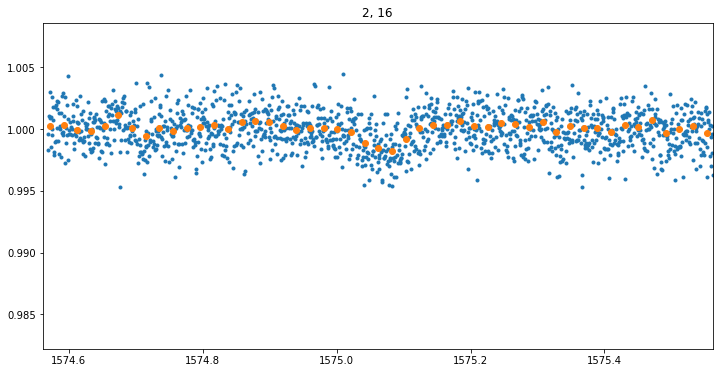

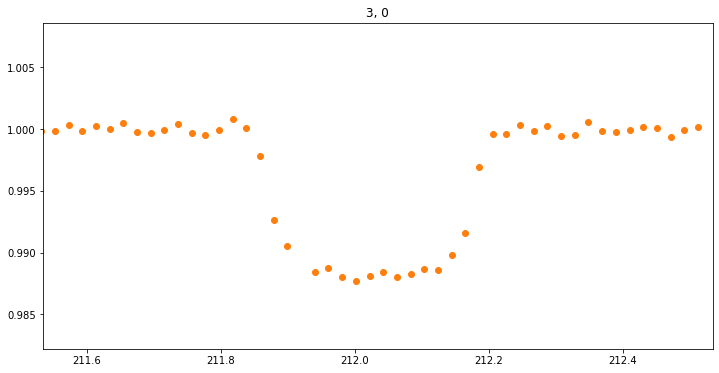

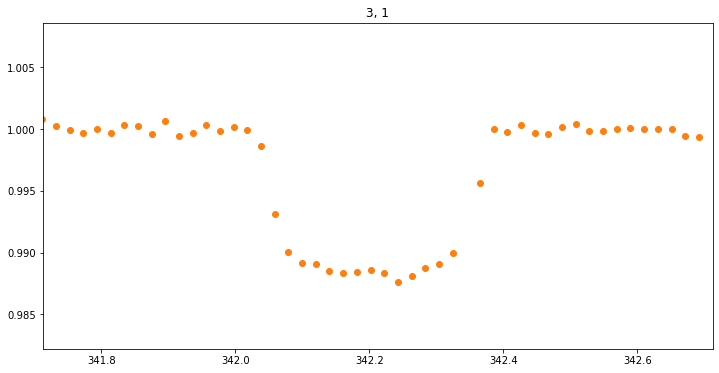

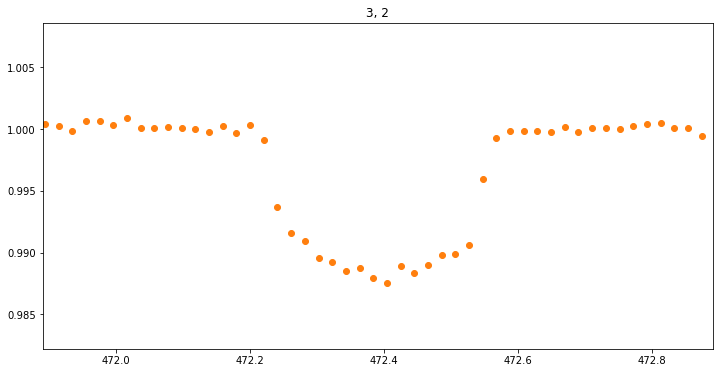

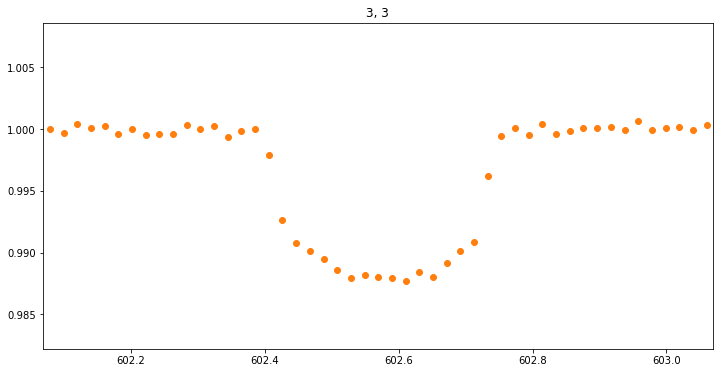

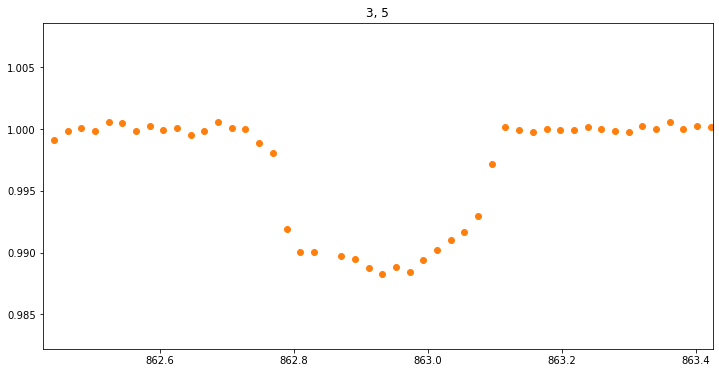

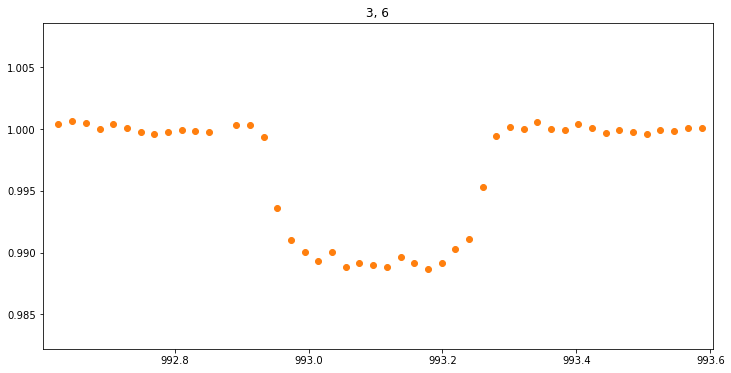

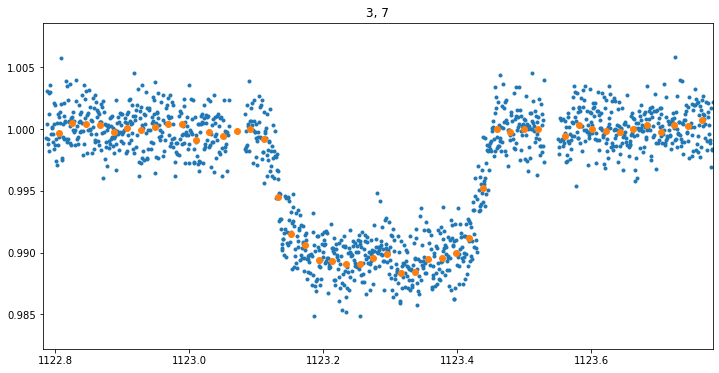

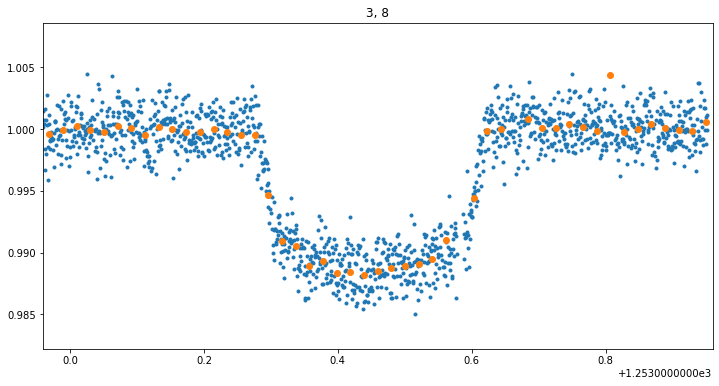

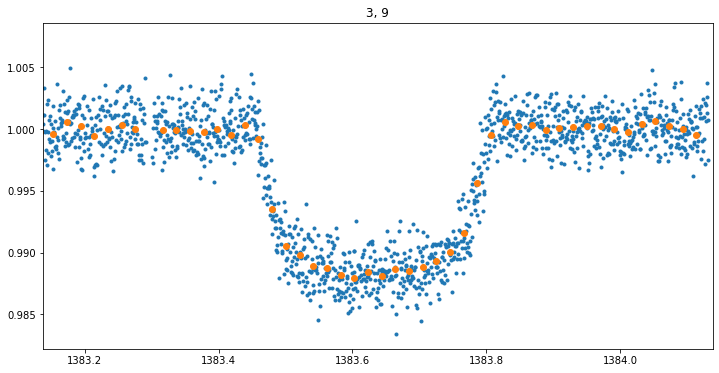

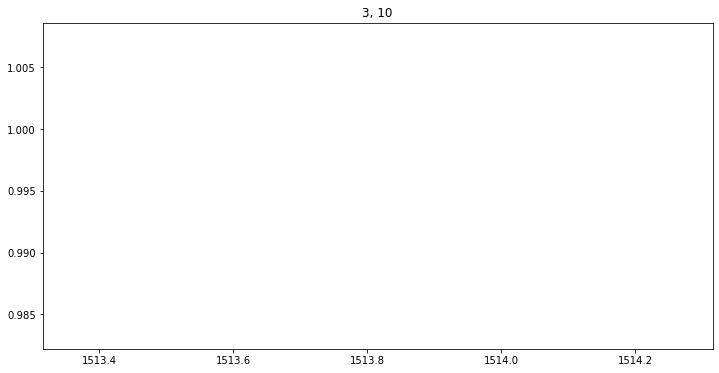

In [92]:
for pl,N,tc in zip(dt.pidx, dt.N, dt.tn):
    plt.figure()
    plt.title("%d, %d"%(pl,N))
    plt.xlim(tc-0.5, tc+0.5)
    plt.plot(df_sc.time, df_sc.flux, '.')
    plt.plot(df_lc.time, df_lc.flux, 'o')

## double transit

In [21]:
dt[dt.Over==1]

KOI   N           tn    O-C  e_O-C f_O-C     TDV   e_TDV f_TDV    TPV  \
29  620.01  30  1513.766640  22.44    1.0        0.3280  0.0049        1.740   
52  620.02  10  1513.815888 -44.07    0.9       -0.0356  0.0041        0.464   

     e_TPV f_TPV  Out  Over  pidx           tc     tcerr  
29  0.0053         60     1     1  1513.782223  0.000694  
52  0.0053         48     1     3  1513.785284  0.000625

In [22]:
tc_double = np.mean(dt[dt.Over==1].tc)

In [23]:
result_sc = result_all[np.array(result_all.exptime) == 60]

In [24]:
result_sc

SearchResult containing 17 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 12 2012 Kepler      60 kplr011773022      0.0
  1 Kepler Quarter 12 2012 Kepler      60 kplr011773022      0.0
  2 Kepler Quarter 12 2012 Kepler      60 kplr011773022      0.0
  3 Kepler Quarter 13 2012 Kepler      60 kplr011773022      0.0
  4 Kepler Quarter 13 2012 Kepler      60 kplr011773022      0.0
  5 Kepler Quarter 13 2012 Kepler      60 kplr011773022      0.0
  6 Kepler Quarter 14 2012 Kepler      60 kplr011773022      0.0
  7 Kepler Quarter 14 2012 Kepler      60 kplr011773022      0.0
  8 Kepler Quarter 14 2012 Kepler      60 kplr011773022      0.0
  9 Kepler Quarter 15 2012 Kepler      60 kplr011773022      0.0
 10 Kepler Quarter 15 2012 Kepler      60 kplr011773022      0.0
 11 Kepler Quarter 15 2013 Kepler      60 kplr011773022      0.0
 12 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 13 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 14 Kepler Quarter 16 2013 Kepler      60 kplr011773022      0.0
 15 Kepler Quarter 17 2013 Kepler      60 kplr011773022      0.0
 16 Kepler Quarter 17 2013 Kepler      60 kplr011773022      0.0

In [25]:
lc_data_q16 = result_sc[13].download_all()

In [26]:
t, f, e, qual = lc_quarter(lc_data_q16, 0)
idxd = np.abs(t - tc_double) < 1.5
t, f, e, qual = t[idxd], f[idxd], e[idxd], qual[idxd]

In [29]:
filter_period = 1.5

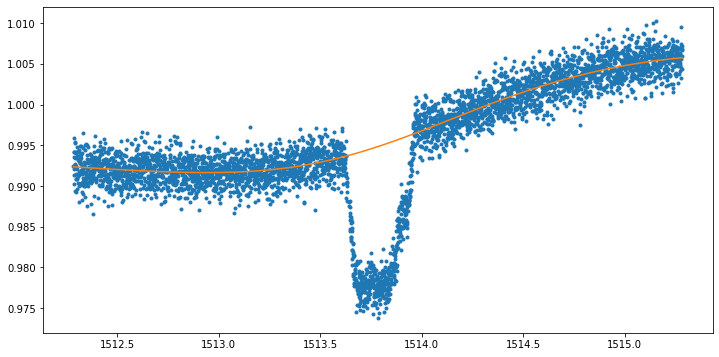

In [30]:
idx = qual==0
plt.plot(t[idx], f[idx], '.')
fbase = fourier_baseline(t[idx], f[idx], filter_period)
plt.plot(t[idx], fbase)

In [31]:
tout = t[idx]
fout = f[idx] / fbase
eout = e[idx] / fbase

In [32]:
len(tout)

4301

1430

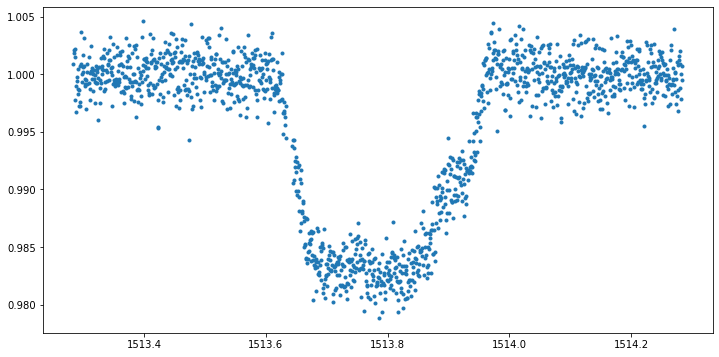

In [34]:
idxo = np.abs(tout - tc_double) < 0.5
#plt.xlim(tc_double-0.5, tc_double+0.5)
plt.plot(tout[idxo], fout[idxo], '.')
np.sum(idxo)

In [35]:
pd.DataFrame(data={"time": tout[idxo], "flux": fout[idxo], "error": eout[idxo]}).to_csv("lc_double.txt", index=False)